# Session 20 Project 6 - Deep Learning Project On Image classification

## Loading the CIFAR-10 dataset

In [14]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


## Data analysis and preprocessing

In [18]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

In [19]:
# Load labels from the dataset
def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [20]:
# Defining a helper function for loading a batch of images
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [21]:
#Defining a function to show the stats for batch ans specific sample
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 6:
Image - Min Value: 30 Max Value: 242
Image - Shape: (32, 32, 3)
Label - Label Id: 8 Name: ship


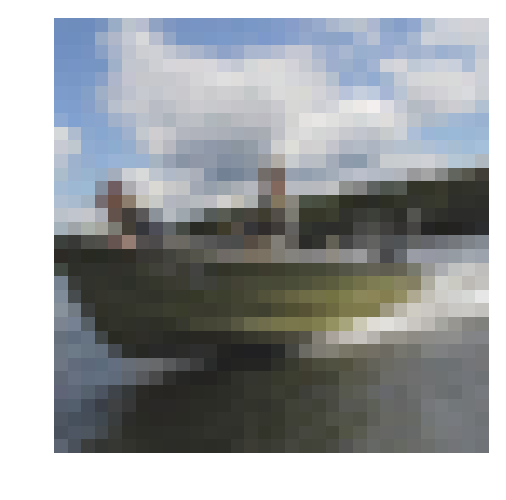

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore a specific batch and sample from the dataset
batch_id = 3
sample_id = 6
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

#### Apply normalization and 1-hot encoding to dataset

In [24]:
#Function used to normalize CIFAR-10 images to be in the range of [0,1]
def normalize(images):        
    # initial zero ndarray    
    normalized_images = np.zeros_like(images.astype(float))        
    
    # The first images index is number of images where the other indices indicates    
    # hieight, width and depth of the image    
    num_images = images.shape[0]        
    
    # Computing the minimum and maximum value of the input image to do the normalization based on them    
    maximum_value, minimum_value = images.max(), images.min()        
    
    # Normalize all the pixel values of the images to be from 0 to 1    
    for img in range(num_images):        
        normalized_images[img,...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)    
    return normalized_images

In [29]:
# encoding the input images. Each image will be represented by a vector of zeros except for the class index of the image 
# that this vector represents. The length of this vector depends on number of classes that we have
# the dataset which is 10 in CIFAR-10

from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(images):        
    num_classes = 10        
    
    #use sklearn helper function of OneHotEncoder() to do that     
    encoder = OneHotEncoder(num_classes)        
    
    #resize the input images to be 2D    
    input_images_resized_to_2d = np.array(images).reshape(-1,1)    
    one_hot_encoded_targets = encoder.fit_transform(input_images_resized_to_2d)
    
    return one_hot_encoded_targets.toarray()

In [67]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1)

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the training data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all training data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_test.p')

In [70]:
# Call function for preprocessing of the data
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [32]:
# Load the Preprocessed Validation data
valid_input_features, valid_input_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Model Building

In [33]:
# Defining the model inputs
def images_input(img_shape): 
    return tf.placeholder(tf.float32, (None, ) + img_shape, name="input_images")

def target_input(num_classes):  
    target_input = tf.placeholder(tf.int32, (None, num_classes), name="input_images_target") 
    return target_input

#define a function for the dropout layer keep probability
def keep_prob_input(): 
    return tf.placeholder(tf.float32, name="keep_prob")

In [34]:
# Applying a convolution operation to the input tensor followed by max pooling
def conv2d_layer(input_tensor, conv_layer_num_outputs, conv_kernel_size, conv_layer_strides, pool_kernel_size, pool_layer_strides): 
    input_depth = input_tensor.get_shape()[3].value 
    weight_shape = conv_kernel_size + (input_depth, conv_layer_num_outputs,)   
    
    #Defining layer weights and biases 
    weights = tf.Variable(tf.random_normal(weight_shape)) 
    biases = tf.Variable(tf.random_normal((conv_layer_num_outputs,)))  
    
    #Considering the biase variable 
    conv_strides = (1,) + conv_layer_strides + (1,)
    
    conv_layer = tf.nn.conv2d(input_tensor, weights, strides=conv_strides, padding='SAME') 
    conv_layer = tf.nn.bias_add(conv_layer, biases) 
    
    conv_kernel_size = (1,) + conv_kernel_size + (1,) 
    
    pool_strides = (1,) + pool_layer_strides + (1,) 
    pool_layer = tf.nn.max_pool(conv_layer, ksize=conv_kernel_size, strides=pool_strides, padding='SAME') 
    
    return pool_layer

In [35]:
#Flatten the output of max pooling layer to be fing to the fully connected layer which only accepts the output
# to be in 2D
def flatten_layer(input_tensor):
    return tf.contrib.layers.flatten(input_tensor)

In [36]:
#Define the fully connected layer that will use the flattened output of the stacked convolution layers
#to do the actuall classification
def fully_connected_layer(input_tensor, num_outputs): 
    return tf.layers.dense(input_tensor, num_outputs)

In [37]:
#Defining the output function
def output_layer(input_tensor, num_outputs):    
    return  tf.layers.dense(input_tensor, num_outputs)

In [38]:
def build_convolution_net(image_data, keep_prob):  
    # Applying 3 convolution layers followed by max pooling layers 
    conv_layer_1 = conv2d_layer(image_data, 32, (3,3), (1,1), (3,3), (3,3))  
    conv_layer_2 = conv2d_layer(conv_layer_1, 64, (3,3), (1,1), (3,3), (3,3)) 
    conv_layer_3 = conv2d_layer(conv_layer_2, 128, (3,3), (1,1), (3,3), (3,3))
    
    # Flatten the output from 4D to 2D to be fed to the fully connected layer 
    flatten_output = flatten_layer(conv_layer_3)
    
    # Applying 2 fully connected layers with drop out 
    fully_connected_layer_1 = fully_connected_layer(flatten_output, 64) 
    fully_connected_layer_1 = tf.nn.dropout(fully_connected_layer_1, keep_prob) 
    fully_connected_layer_2 = fully_connected_layer(fully_connected_layer_1, 32) 
    fully_connected_layer_2 = tf.nn.dropout(fully_connected_layer_2, keep_prob)  
    
    #Applying the output layer while the output size will be the number of categories that we have 
    #in CIFAR-10 dataset 
    output_logits = output_layer(fully_connected_layer_2, 10)
    
    #returning output 
    return output_logits

In [46]:
def test_conv_net(conv_net):
    test_x = tf.placeholder(tf.float32, [None, 32, 32, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = conv_net(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print('Neural Network Built!')

In [47]:
#Using the helper function above to build the network
#First off, let's remove all the previous inputs, weights, biases form the previous runs
tf.reset_default_graph()

# Defining the input placeholders to the convolution neural network
input_images = images_input((32, 32, 3))
input_images_target = target_input(10)
keep_prob = keep_prob_input()

# Building the models
logits_values = build_convolution_net(input_images, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits_values = tf.identity(logits_values, name='logits')

# defining the model loss
model_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_values, labels=input_images_target))

# Defining the model optimizer
model_optimizer = tf.train.AdamOptimizer().minimize(model_cost)

# Calculating and averaging the model accuracy
correct_prediction = tf.equal(tf.argmax(logits_values, 1), tf.argmax(input_images_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='model_accuracy')

In [48]:
test_conv_net(build_convolution_net)

Neural Network Built!


## Training Model

In [49]:
#Define a helper function for kicking off the training process
def train(session, model_optimizer, keep_probability, in_feature_batch, target_batch):
    session.run(model_optimizer, feed_dict={input_images: in_feature_batch, input_images_target: target_batch, keep_prob: keep_probability})

In [50]:
#Defining a helper funcitno for print information about the model accuracy and it's validation accuracy as well
def print_model_stats(session, input_feature_batch, target_label_batch, model_cost, model_accuracy):        
    validation_loss = session.run(model_cost, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})    
    validation_accuracy = session.run(model_accuracy, feed_dict={input_images: input_feature_batch, input_images_target: target_label_batch, keep_prob: 1.0})        
    
    print("Valid Loss: %f" %(validation_loss))    
    print("Valid accuracy: %f" % (validation_accuracy))

In [51]:
# Model Hyperparameters
num_epochs = 100
batch_size = 128
keep_probability = 0.5

In [52]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

In [57]:
print('Training on only a Single Batch from the CIFAR-10 Dataset...')
with tf.Session() as sess:  
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    # Training cycle 
    for epoch in range(num_epochs): 
        batch_ind = 1  
        for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
            train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
            
            print('Epoch number {:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
            print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)

Training on only a Single Batch from the CIFAR-10 Dataset...
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 2002.778198
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1701.629639
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1195.939941
Valid accuracy: 0.078125
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1432.352173
Valid accuracy: 0.125000
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1648.861450
Valid accuracy: 0.156250
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 1305.102783
Valid accuracy: 0.093750
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 845.705688
Valid accuracy: 0.109375
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 845.989380
Valid accuracy: 0.148438
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 852.135620
Valid accuracy: 0.171875
Epoch number  1, CIFAR-10 Batch Number 1: Valid Loss: 801.145142
Valid accuracy: 0.164062
Epoch number  1, CIFAR-10 Batch N

Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 184.059875
Valid accuracy: 0.320312
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 166.342728
Valid accuracy: 0.351562
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 150.071625
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 154.663010
Valid accuracy: 0.351562
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 110.246857
Valid accuracy: 0.359375
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 125.342545
Valid accuracy: 0.375000
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 151.075272
Valid accuracy: 0.382812
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 146.057556
Valid accuracy: 0.304688
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 172.870392
Valid accuracy: 0.359375
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 147.652328
Valid accuracy: 0.335938
Epoch number  3, CIFAR-10 Batch Number 1: Valid Loss: 114.015518
Valid accuracy: 0.398438
Epoch numb

Valid accuracy: 0.343750
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 63.588524
Valid accuracy: 0.351562
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 51.774017
Valid accuracy: 0.429688
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 59.782543
Valid accuracy: 0.437500
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 63.516724
Valid accuracy: 0.429688
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 74.288239
Valid accuracy: 0.320312
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 53.915115
Valid accuracy: 0.437500
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 77.213333
Valid accuracy: 0.414062
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 61.255459
Valid accuracy: 0.460938
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 51.129410
Valid accuracy: 0.398438
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 61.773857
Valid accuracy: 0.320312
Epoch number  6, CIFAR-10 Batch Number 1: Valid Loss: 67.102379
Valid accuracy: 0.406

Valid accuracy: 0.453125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 37.138096
Valid accuracy: 0.304688
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 31.205999
Valid accuracy: 0.437500
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 39.956192
Valid accuracy: 0.398438
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 23.227028
Valid accuracy: 0.484375
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 32.427486
Valid accuracy: 0.453125
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 32.355034
Valid accuracy: 0.468750
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 34.250927
Valid accuracy: 0.406250
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 29.913223
Valid accuracy: 0.492188
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 38.862305
Valid accuracy: 0.382812
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 38.200699
Valid accuracy: 0.390625
Epoch number  8, CIFAR-10 Batch Number 1: Valid Loss: 39.099789
Valid accuracy: 0.445

Valid accuracy: 0.406250
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 15.068714
Valid accuracy: 0.531250
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.650497
Valid accuracy: 0.476562
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.917946
Valid accuracy: 0.406250
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 22.347469
Valid accuracy: 0.460938
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 20.117928
Valid accuracy: 0.421875
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 18.361004
Valid accuracy: 0.445312
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 24.230629
Valid accuracy: 0.445312
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 17.810211
Valid accuracy: 0.500000
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 21.421537
Valid accuracy: 0.390625
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 19.842934
Valid accuracy: 0.515625
Epoch number 11, CIFAR-10 Batch Number 1: Valid Loss: 16.218761
Valid accuracy: 0.484

Valid accuracy: 0.453125
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 12.312557
Valid accuracy: 0.445312
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 10.133601
Valid accuracy: 0.500000
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 13.057642
Valid accuracy: 0.468750
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 9.700594
Valid accuracy: 0.500000
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 10.773885
Valid accuracy: 0.437500
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 13.518554
Valid accuracy: 0.398438
Epoch number 13, CIFAR-10 Batch Number 1: Valid Loss: 9.457345
Valid accuracy: 0.625000
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 11.765274
Valid accuracy: 0.460938
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 8.179019
Valid accuracy: 0.507812
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 10.697729
Valid accuracy: 0.484375
Epoch number 14, CIFAR-10 Batch Number 1: Valid Loss: 11.666840
Valid accuracy: 0.468750

Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.056235
Valid accuracy: 0.507812
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.090039
Valid accuracy: 0.390625
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.883244
Valid accuracy: 0.414062
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 7.433243
Valid accuracy: 0.320312
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 8.241651
Valid accuracy: 0.414062
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.993459
Valid accuracy: 0.531250
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 6.423079
Valid accuracy: 0.429688
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.848467
Valid accuracy: 0.523438
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.522552
Valid accuracy: 0.460938
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 5.322207
Valid accuracy: 0.414062
Epoch number 16, CIFAR-10 Batch Number 1: Valid Loss: 4.003267
Valid accuracy: 0.398438
Epoch number 16, CIFAR-10 Batch 

Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.567197
Valid accuracy: 0.429688
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.166161
Valid accuracy: 0.414062
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.427783
Valid accuracy: 0.406250
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.541295
Valid accuracy: 0.437500
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.975202
Valid accuracy: 0.335938
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.038995
Valid accuracy: 0.421875
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 3.580754
Valid accuracy: 0.335938
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.692638
Valid accuracy: 0.445312
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.468762
Valid accuracy: 0.437500
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.757873
Valid accuracy: 0.367188
Epoch number 19, CIFAR-10 Batch Number 1: Valid Loss: 2.478941
Valid accuracy: 0.445312
Epoch number 19, CIFAR-10 Batch 

Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.765353
Valid accuracy: 0.351562
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.560292
Valid accuracy: 0.476562
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.672558
Valid accuracy: 0.398438
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.629242
Valid accuracy: 0.351562
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.690794
Valid accuracy: 0.359375
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.572716
Valid accuracy: 0.429688
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.824543
Valid accuracy: 0.359375
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.691279
Valid accuracy: 0.343750
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.741709
Valid accuracy: 0.406250
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.718738
Valid accuracy: 0.359375
Epoch number 21, CIFAR-10 Batch Number 1: Valid Loss: 1.722167
Valid accuracy: 0.351562
Epoch number 21, CIFAR-10 Batch 

Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.756765
Valid accuracy: 0.406250
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.641845
Valid accuracy: 0.421875
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.765971
Valid accuracy: 0.406250
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.657918
Valid accuracy: 0.406250
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.766439
Valid accuracy: 0.382812
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.655835
Valid accuracy: 0.453125
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.692780
Valid accuracy: 0.382812
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.712776
Valid accuracy: 0.414062
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.664253
Valid accuracy: 0.359375
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.745040
Valid accuracy: 0.304688
Epoch number 24, CIFAR-10 Batch Number 1: Valid Loss: 1.689986
Valid accuracy: 0.437500
Epoch number 24, CIFAR-10 Batch 

Epoch number 26, CIFAR-10 Batch Number 1: Valid Loss: 1.775155
Valid accuracy: 0.375000
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.747300
Valid accuracy: 0.359375
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.602531
Valid accuracy: 0.414062
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.677847
Valid accuracy: 0.367188
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.845115
Valid accuracy: 0.289062
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.745110
Valid accuracy: 0.375000
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.721426
Valid accuracy: 0.320312
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.808158
Valid accuracy: 0.351562
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.665025
Valid accuracy: 0.343750
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.731308
Valid accuracy: 0.335938
Epoch number 27, CIFAR-10 Batch Number 1: Valid Loss: 1.736450
Valid accuracy: 0.351562
Epoch number 27, CIFAR-10 Batch 

Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.645659
Valid accuracy: 0.375000
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.751383
Valid accuracy: 0.351562
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.715652
Valid accuracy: 0.335938
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.675058
Valid accuracy: 0.375000
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.697413
Valid accuracy: 0.375000
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.678373
Valid accuracy: 0.390625
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.627097
Valid accuracy: 0.492188
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.663958
Valid accuracy: 0.398438
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.753019
Valid accuracy: 0.335938
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.670585
Valid accuracy: 0.398438
Epoch number 29, CIFAR-10 Batch Number 1: Valid Loss: 1.761708
Valid accuracy: 0.390625
Epoch number 29, CIFAR-10 Batch 

Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.739960
Valid accuracy: 0.382812
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.725085
Valid accuracy: 0.328125
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.678014
Valid accuracy: 0.414062
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.666384
Valid accuracy: 0.421875
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.663856
Valid accuracy: 0.375000
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.719169
Valid accuracy: 0.382812
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.648373
Valid accuracy: 0.414062
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.688783
Valid accuracy: 0.398438
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.642932
Valid accuracy: 0.375000
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.720769
Valid accuracy: 0.437500
Epoch number 32, CIFAR-10 Batch Number 1: Valid Loss: 1.760774
Valid accuracy: 0.375000
Epoch number 32, CIFAR-10 Batch 

Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.777303
Valid accuracy: 0.312500
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.805640
Valid accuracy: 0.382812
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.722904
Valid accuracy: 0.382812
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.646802
Valid accuracy: 0.453125
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.721545
Valid accuracy: 0.335938
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.649239
Valid accuracy: 0.414062
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.739550
Valid accuracy: 0.320312
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.661435
Valid accuracy: 0.445312
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.704875
Valid accuracy: 0.335938
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.767925
Valid accuracy: 0.390625
Epoch number 34, CIFAR-10 Batch Number 1: Valid Loss: 1.733977
Valid accuracy: 0.375000
Epoch number 35, CIFAR-10 Batch 

Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.707087
Valid accuracy: 0.390625
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.682353
Valid accuracy: 0.343750
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.748069
Valid accuracy: 0.343750
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.677594
Valid accuracy: 0.421875
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.752085
Valid accuracy: 0.375000
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.781421
Valid accuracy: 0.359375
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.792817
Valid accuracy: 0.335938
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.750598
Valid accuracy: 0.414062
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.639132
Valid accuracy: 0.453125
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.773138
Valid accuracy: 0.367188
Epoch number 37, CIFAR-10 Batch Number 1: Valid Loss: 1.612494
Valid accuracy: 0.375000
Epoch number 37, CIFAR-10 Batch 

Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.795908
Valid accuracy: 0.367188
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.626668
Valid accuracy: 0.421875
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.635064
Valid accuracy: 0.437500
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.616251
Valid accuracy: 0.406250
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.632784
Valid accuracy: 0.382812
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.654041
Valid accuracy: 0.429688
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.622695
Valid accuracy: 0.453125
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.725060
Valid accuracy: 0.359375
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.627357
Valid accuracy: 0.437500
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.786612
Valid accuracy: 0.382812
Epoch number 40, CIFAR-10 Batch Number 1: Valid Loss: 1.718832
Valid accuracy: 0.390625
Epoch number 40, CIFAR-10 Batch 

Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.694255
Valid accuracy: 0.351562
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.747797
Valid accuracy: 0.359375
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.645869
Valid accuracy: 0.382812
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.766535
Valid accuracy: 0.320312
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.564835
Valid accuracy: 0.445312
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.677650
Valid accuracy: 0.375000
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.688125
Valid accuracy: 0.382812
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.723629
Valid accuracy: 0.335938
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.568213
Valid accuracy: 0.421875
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.764175
Valid accuracy: 0.351562
Epoch number 42, CIFAR-10 Batch Number 1: Valid Loss: 1.706188
Valid accuracy: 0.414062
Epoch number 42, CIFAR-10 Batch 

Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.686923
Valid accuracy: 0.414062
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.618659
Valid accuracy: 0.398438
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.625224
Valid accuracy: 0.445312
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.728562
Valid accuracy: 0.398438
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.735429
Valid accuracy: 0.367188
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.692523
Valid accuracy: 0.421875
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.607734
Valid accuracy: 0.359375
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.756564
Valid accuracy: 0.320312
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.564332
Valid accuracy: 0.484375
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.651362
Valid accuracy: 0.390625
Epoch number 45, CIFAR-10 Batch Number 1: Valid Loss: 1.698873
Valid accuracy: 0.398438
Epoch number 45, CIFAR-10 Batch 

Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.560474
Valid accuracy: 0.437500
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.699105
Valid accuracy: 0.406250
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.710412
Valid accuracy: 0.375000
Epoch number 47, CIFAR-10 Batch Number 1: Valid Loss: 1.711713
Valid accuracy: 0.375000
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.698918
Valid accuracy: 0.406250
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.515531
Valid accuracy: 0.468750
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.595112
Valid accuracy: 0.406250
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.778582
Valid accuracy: 0.382812
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.664850
Valid accuracy: 0.437500
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.673725
Valid accuracy: 0.343750
Epoch number 48, CIFAR-10 Batch Number 1: Valid Loss: 1.680944
Valid accuracy: 0.429688
Epoch number 48, CIFAR-10 Batch 

Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.685669
Valid accuracy: 0.367188
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.573051
Valid accuracy: 0.453125
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.725505
Valid accuracy: 0.406250
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.573353
Valid accuracy: 0.476562
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.744349
Valid accuracy: 0.390625
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.740983
Valid accuracy: 0.367188
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.619624
Valid accuracy: 0.421875
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.629876
Valid accuracy: 0.390625
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.617246
Valid accuracy: 0.445312
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.636712
Valid accuracy: 0.484375
Epoch number 50, CIFAR-10 Batch Number 1: Valid Loss: 1.622312
Valid accuracy: 0.406250
Epoch number 50, CIFAR-10 Batch 

Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.687810
Valid accuracy: 0.390625
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.574173
Valid accuracy: 0.437500
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.773676
Valid accuracy: 0.406250
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.668328
Valid accuracy: 0.367188
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.599737
Valid accuracy: 0.421875
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.597019
Valid accuracy: 0.414062
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.570371
Valid accuracy: 0.421875
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.609954
Valid accuracy: 0.375000
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.688255
Valid accuracy: 0.375000
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.575297
Valid accuracy: 0.468750
Epoch number 53, CIFAR-10 Batch Number 1: Valid Loss: 1.660084
Valid accuracy: 0.421875
Epoch number 53, CIFAR-10 Batch 

Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.655005
Valid accuracy: 0.414062
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.539430
Valid accuracy: 0.445312
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.726408
Valid accuracy: 0.359375
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.634149
Valid accuracy: 0.382812
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.697285
Valid accuracy: 0.406250
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.653996
Valid accuracy: 0.445312
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.570478
Valid accuracy: 0.460938
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.637353
Valid accuracy: 0.406250
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.621474
Valid accuracy: 0.437500
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.644884
Valid accuracy: 0.390625
Epoch number 55, CIFAR-10 Batch Number 1: Valid Loss: 1.580841
Valid accuracy: 0.437500
Epoch number 55, CIFAR-10 Batch 

Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.753735
Valid accuracy: 0.359375
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.611280
Valid accuracy: 0.398438
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.598734
Valid accuracy: 0.429688
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.654331
Valid accuracy: 0.406250
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.619279
Valid accuracy: 0.343750
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.681770
Valid accuracy: 0.351562
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.657153
Valid accuracy: 0.398438
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.673392
Valid accuracy: 0.406250
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.653537
Valid accuracy: 0.406250
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.717649
Valid accuracy: 0.382812
Epoch number 58, CIFAR-10 Batch Number 1: Valid Loss: 1.731516
Valid accuracy: 0.367188
Epoch number 58, CIFAR-10 Batch 

Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.754912
Valid accuracy: 0.390625
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.606675
Valid accuracy: 0.421875
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.597018
Valid accuracy: 0.445312
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.734283
Valid accuracy: 0.304688
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.657738
Valid accuracy: 0.367188
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.616928
Valid accuracy: 0.414062
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.505637
Valid accuracy: 0.476562
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.611248
Valid accuracy: 0.390625
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.638240
Valid accuracy: 0.421875
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.621370
Valid accuracy: 0.390625
Epoch number 61, CIFAR-10 Batch Number 1: Valid Loss: 1.631771
Valid accuracy: 0.414062
Epoch number 61, CIFAR-10 Batch 

Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.611185
Valid accuracy: 0.390625
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.629386
Valid accuracy: 0.429688
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.630335
Valid accuracy: 0.414062
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.605996
Valid accuracy: 0.382812
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.799330
Valid accuracy: 0.328125
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.574430
Valid accuracy: 0.460938
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.699108
Valid accuracy: 0.375000
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.434610
Valid accuracy: 0.453125
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.611642
Valid accuracy: 0.429688
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.605041
Valid accuracy: 0.437500
Epoch number 63, CIFAR-10 Batch Number 1: Valid Loss: 1.630740
Valid accuracy: 0.359375
Epoch number 63, CIFAR-10 Batch 

Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.650734
Valid accuracy: 0.375000
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.631317
Valid accuracy: 0.398438
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.591687
Valid accuracy: 0.414062
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.600382
Valid accuracy: 0.421875
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.565326
Valid accuracy: 0.445312
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.576727
Valid accuracy: 0.445312
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.655891
Valid accuracy: 0.429688
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.589529
Valid accuracy: 0.398438
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.594284
Valid accuracy: 0.500000
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.495671
Valid accuracy: 0.398438
Epoch number 66, CIFAR-10 Batch Number 1: Valid Loss: 1.618983
Valid accuracy: 0.390625
Epoch number 66, CIFAR-10 Batch 

Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.637235
Valid accuracy: 0.398438
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.520047
Valid accuracy: 0.492188
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.648935
Valid accuracy: 0.359375
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.586210
Valid accuracy: 0.421875
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.603648
Valid accuracy: 0.421875
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.669962
Valid accuracy: 0.414062
Epoch number 68, CIFAR-10 Batch Number 1: Valid Loss: 1.600465
Valid accuracy: 0.400000
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.667114
Valid accuracy: 0.343750
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.501764
Valid accuracy: 0.437500
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.567459
Valid accuracy: 0.429688
Epoch number 69, CIFAR-10 Batch Number 1: Valid Loss: 1.756416
Valid accuracy: 0.406250
Epoch number 69, CIFAR-10 Batch 

Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.632248
Valid accuracy: 0.390625
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.691168
Valid accuracy: 0.382812
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.687016
Valid accuracy: 0.382812
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.660865
Valid accuracy: 0.390625
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.544035
Valid accuracy: 0.484375
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.651761
Valid accuracy: 0.453125
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.468627
Valid accuracy: 0.492188
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.591371
Valid accuracy: 0.414062
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.620096
Valid accuracy: 0.367188
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.546227
Valid accuracy: 0.437500
Epoch number 71, CIFAR-10 Batch Number 1: Valid Loss: 1.609163
Valid accuracy: 0.382812
Epoch number 71, CIFAR-10 Batch 

Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.653692
Valid accuracy: 0.335938
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.553168
Valid accuracy: 0.429688
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.463686
Valid accuracy: 0.507812
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.619281
Valid accuracy: 0.343750
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.450430
Valid accuracy: 0.500000
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.714424
Valid accuracy: 0.351562
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.555252
Valid accuracy: 0.414062
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.525381
Valid accuracy: 0.484375
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.542919
Valid accuracy: 0.398438
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.552587
Valid accuracy: 0.437500
Epoch number 74, CIFAR-10 Batch Number 1: Valid Loss: 1.571162
Valid accuracy: 0.445312
Epoch number 74, CIFAR-10 Batch 

Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.424919
Valid accuracy: 0.507812
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.541092
Valid accuracy: 0.429688
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.522056
Valid accuracy: 0.437500
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.634983
Valid accuracy: 0.390625
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.483804
Valid accuracy: 0.421875
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.680402
Valid accuracy: 0.375000
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.627237
Valid accuracy: 0.421875
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.596274
Valid accuracy: 0.445312
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.541597
Valid accuracy: 0.460938
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.533967
Valid accuracy: 0.382812
Epoch number 76, CIFAR-10 Batch Number 1: Valid Loss: 1.579463
Valid accuracy: 0.437500
Epoch number 76, CIFAR-10 Batch 

Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.526806
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.592611
Valid accuracy: 0.492188
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.472282
Valid accuracy: 0.437500
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.653004
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.566923
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.521227
Valid accuracy: 0.437500
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.566282
Valid accuracy: 0.476562
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.505260
Valid accuracy: 0.460938
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.600058
Valid accuracy: 0.437500
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.448636
Valid accuracy: 0.492188
Epoch number 79, CIFAR-10 Batch Number 1: Valid Loss: 1.556346
Valid accuracy: 0.421875
Epoch number 79, CIFAR-10 Batch 

Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.629580
Valid accuracy: 0.390625
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.403397
Valid accuracy: 0.476562
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.511816
Valid accuracy: 0.460938
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.657655
Valid accuracy: 0.351562
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.575925
Valid accuracy: 0.421875
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.492443
Valid accuracy: 0.500000
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.650834
Valid accuracy: 0.367188
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.493263
Valid accuracy: 0.460938
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.467336
Valid accuracy: 0.445312
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.446348
Valid accuracy: 0.453125
Epoch number 82, CIFAR-10 Batch Number 1: Valid Loss: 1.525609
Valid accuracy: 0.390625
Epoch number 82, CIFAR-10 Batch 

Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.576430
Valid accuracy: 0.484375
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.495047
Valid accuracy: 0.445312
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.518926
Valid accuracy: 0.421875
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.629452
Valid accuracy: 0.375000
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.551338
Valid accuracy: 0.375000
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.442408
Valid accuracy: 0.507812
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.538893
Valid accuracy: 0.398438
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.633862
Valid accuracy: 0.382812
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.593929
Valid accuracy: 0.382812
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.624427
Valid accuracy: 0.421875
Epoch number 84, CIFAR-10 Batch Number 1: Valid Loss: 1.399856
Valid accuracy: 0.492188
Epoch number 84, CIFAR-10 Batch 

Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.434360
Valid accuracy: 0.500000
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.486549
Valid accuracy: 0.515625
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.435975
Valid accuracy: 0.492188
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.455880
Valid accuracy: 0.476562
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.632132
Valid accuracy: 0.343750
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.435110
Valid accuracy: 0.445312
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.496027
Valid accuracy: 0.500000
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.424308
Valid accuracy: 0.460938
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.497622
Valid accuracy: 0.468750
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.565313
Valid accuracy: 0.398438
Epoch number 87, CIFAR-10 Batch Number 1: Valid Loss: 1.496030
Valid accuracy: 0.453125
Epoch number 87, CIFAR-10 Batch 

Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.565516
Valid accuracy: 0.453125
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.528996
Valid accuracy: 0.453125
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.479084
Valid accuracy: 0.445312
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.544694
Valid accuracy: 0.414062
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.449821
Valid accuracy: 0.468750
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.607728
Valid accuracy: 0.398438
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.473965
Valid accuracy: 0.476562
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.603738
Valid accuracy: 0.406250
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.534247
Valid accuracy: 0.453125
Epoch number 89, CIFAR-10 Batch Number 1: Valid Loss: 1.460263
Valid accuracy: 0.575000
Epoch number 90, CIFAR-10 Batch Number 1: Valid Loss: 1.598635
Valid accuracy: 0.414062
Epoch number 90, CIFAR-10 Batch 

Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.386420
Valid accuracy: 0.492188
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.532048
Valid accuracy: 0.445312
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.412640
Valid accuracy: 0.476562
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.574136
Valid accuracy: 0.476562
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.531835
Valid accuracy: 0.476562
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.633316
Valid accuracy: 0.382812
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.625474
Valid accuracy: 0.398438
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.449671
Valid accuracy: 0.531250
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.539573
Valid accuracy: 0.460938
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.385417
Valid accuracy: 0.523438
Epoch number 92, CIFAR-10 Batch Number 1: Valid Loss: 1.455506
Valid accuracy: 0.460938
Epoch number 92, CIFAR-10 Batch 

Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.539685
Valid accuracy: 0.437500
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.500308
Valid accuracy: 0.507812
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.377212
Valid accuracy: 0.539062
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.609744
Valid accuracy: 0.367188
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.516062
Valid accuracy: 0.476562
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.499458
Valid accuracy: 0.476562
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.515129
Valid accuracy: 0.437500
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.376050
Valid accuracy: 0.515625
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.651215
Valid accuracy: 0.406250
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.541118
Valid accuracy: 0.421875
Epoch number 95, CIFAR-10 Batch Number 1: Valid Loss: 1.451888
Valid accuracy: 0.468750
Epoch number 95, CIFAR-10 Batch 

Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.611984
Valid accuracy: 0.453125
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.480512
Valid accuracy: 0.460938
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.617653
Valid accuracy: 0.382812
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.329622
Valid accuracy: 0.500000
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.516350
Valid accuracy: 0.437500
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.439419
Valid accuracy: 0.492188
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.553563
Valid accuracy: 0.414062
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.471490
Valid accuracy: 0.437500
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.591658
Valid accuracy: 0.398438
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.494521
Valid accuracy: 0.468750
Epoch number 97, CIFAR-10 Batch Number 1: Valid Loss: 1.520520
Valid accuracy: 0.500000
Epoch number 97, CIFAR-10 Batch 

Valid accuracy: 0.476562
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.396077
Valid accuracy: 0.500000
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.499255
Valid accuracy: 0.468750
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.547122
Valid accuracy: 0.437500
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.479528
Valid accuracy: 0.437500
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.527220
Valid accuracy: 0.492188
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.473183
Valid accuracy: 0.421875
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.538254
Valid accuracy: 0.421875
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.443697
Valid accuracy: 0.515625
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.426944
Valid accuracy: 0.468750
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.508443
Valid accuracy: 0.445312
Epoch number 100, CIFAR-10 Batch Number 1: Valid Loss: 1.409934
Valid accuracy: 0.476

In [60]:
model_save_path = './cifar-10_classification'

with tf.Session() as sess: 
    # Initializing the variables 
    sess.run(tf.global_variables_initializer())  
    
    # Training cycle 
    for epoch in range(num_epochs):  
        # iterate through the batches 
        num_batches = 5  
        for batch_ind in range(1, num_batches + 1): 
            for batch_features, batch_labels in load_preprocess_training_batch(batch_ind, batch_size): 
                train(sess, model_optimizer, keep_probability, batch_features, batch_labels)  
                print('Epoch number{:>2}, CIFAR-10 Batch Number {}: '.format(epoch + 1, batch_ind), end='') 
                print_model_stats(sess, batch_features, batch_labels, model_cost, accuracy)  
                
    # Save the trained Model 
    saver = tf.train.Saver() 
    save_path = saver.save(sess, model_save_path)

Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1175.010498
Valid accuracy: 0.171875
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1321.126709
Valid accuracy: 0.132812
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1531.062988
Valid accuracy: 0.125000
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1185.289551
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 1025.936890
Valid accuracy: 0.156250
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 794.487915
Valid accuracy: 0.156250
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 994.942444
Valid accuracy: 0.101562
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 754.106750
Valid accuracy: 0.187500
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 510.436157
Valid accuracy: 0.203125
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 700.413696
Valid accuracy: 0.117188
Epoch number 1, CIFAR-10 Batch Number 1: Valid Loss: 827.503296
Valid accuracy: 0.117188
Epoch number 1, 

Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 217.822327
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 161.617157
Valid accuracy: 0.382812
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 184.416229
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 170.394333
Valid accuracy: 0.328125
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 184.164948
Valid accuracy: 0.312500
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 218.983521
Valid accuracy: 0.265625
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 177.907715
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 164.701019
Valid accuracy: 0.312500
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 227.134155
Valid accuracy: 0.312500
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 183.306549
Valid accuracy: 0.320312
Epoch number 1, CIFAR-10 Batch Number 2: Valid Loss: 208.540009
Valid accuracy: 0.265625
Epoch number 1, CIFAR

Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 102.262886
Valid accuracy: 0.304688
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 84.515213
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 94.339783
Valid accuracy: 0.304688
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 59.266144
Valid accuracy: 0.500000
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 68.281563
Valid accuracy: 0.398438
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 54.494484
Valid accuracy: 0.429688
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 70.458954
Valid accuracy: 0.382812
Epoch number 1, CIFAR-10 Batch Number 4: Valid Loss: 68.259468
Valid accuracy: 0.325000
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 52.508419
Valid accuracy: 0.468750
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 87.049484
Valid accuracy: 0.312500
Epoch number 1, CIFAR-10 Batch Number 5: Valid Loss: 71.208878
Valid accuracy: 0.359375
Epoch number 1, CIFAR-10 Batch 

Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 32.409424
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 43.542717
Valid accuracy: 0.398438
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 41.432003
Valid accuracy: 0.414062
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 48.923653
Valid accuracy: 0.375000
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 38.414822
Valid accuracy: 0.367188
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 37.756676
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 47.672459
Valid accuracy: 0.398438
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 39.121925
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 33.174255
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 38.965981
Valid accuracy: 0.390625
Epoch number 2, CIFAR-10 Batch Number 2: Valid Loss: 46.021164
Valid accuracy: 0.359375
Epoch number 2, CIFAR-10 Batch N

Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 19.966488
Valid accuracy: 0.453125
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 19.854179
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 22.590275
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 23.051857
Valid accuracy: 0.367188
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 15.325935
Valid accuracy: 0.523438
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 16.492393
Valid accuracy: 0.437500
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 18.771774
Valid accuracy: 0.468750
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 22.595131
Valid accuracy: 0.429688
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 17.762417
Valid accuracy: 0.484375
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 12.785639
Valid accuracy: 0.554688
Epoch number 2, CIFAR-10 Batch Number 5: Valid Loss: 20.896412
Valid accuracy: 0.406250
Epoch number 2, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 12.306705
Valid accuracy: 0.375000
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 10.498724
Valid accuracy: 0.492188
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 14.789745
Valid accuracy: 0.390625
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 14.100342
Valid accuracy: 0.375000
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 10.213030
Valid accuracy: 0.460938
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 13.619575
Valid accuracy: 0.468750
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 10.710693
Valid accuracy: 0.500000
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 15.106694
Valid accuracy: 0.312500
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 13.199251
Valid accuracy: 0.390625
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 15.456347
Valid accuracy: 0.351562
Epoch number 3, CIFAR-10 Batch Number 2: Valid Loss: 14.470669
Valid accuracy: 0.406250
Epoch number 3, CIFAR-10 Batch N

Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.492124
Valid accuracy: 0.382812
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 5.683446
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.180421
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 8.654871
Valid accuracy: 0.437500
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.251260
Valid accuracy: 0.421875
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.348320
Valid accuracy: 0.453125
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.754595
Valid accuracy: 0.531250
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.772864
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 6.590802
Valid accuracy: 0.445312
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.843928
Valid accuracy: 0.429688
Epoch number 3, CIFAR-10 Batch Number 5: Valid Loss: 7.674844
Valid accuracy: 0.359375
Epoch number 3, CIFAR-10 Batch Number 5: Va

Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.811145
Valid accuracy: 0.359375
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.788860
Valid accuracy: 0.429688
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 4.119720
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 4.310490
Valid accuracy: 0.492188
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.630045
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 4.155832
Valid accuracy: 0.445312
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.669969
Valid accuracy: 0.414062
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.721834
Valid accuracy: 0.531250
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.738915
Valid accuracy: 0.375000
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 3.834114
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 3: Valid Loss: 2.678105
Valid accuracy: 0.468750
Epoch number 4, CIFAR-10 Batch Number 3: Va

Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.888639
Valid accuracy: 0.507812
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.676584
Valid accuracy: 0.351562
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 1.878483
Valid accuracy: 0.382812
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.766040
Valid accuracy: 0.296875
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.512427
Valid accuracy: 0.390625
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.083155
Valid accuracy: 0.328125
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.645754
Valid accuracy: 0.468750
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.670557
Valid accuracy: 0.367188
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.223722
Valid accuracy: 0.328125
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.125523
Valid accuracy: 0.445312
Epoch number 4, CIFAR-10 Batch Number 5: Valid Loss: 2.068226
Valid accuracy: 0.343750
Epoch number 4, CIFAR-10 Batch Number 5: Va

Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 2.243086
Valid accuracy: 0.304688
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.588597
Valid accuracy: 0.406250
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.754706
Valid accuracy: 0.437500
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.624297
Valid accuracy: 0.398438
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.821633
Valid accuracy: 0.414062
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.679064
Valid accuracy: 0.367188
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.873458
Valid accuracy: 0.328125
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.863947
Valid accuracy: 0.453125
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.735387
Valid accuracy: 0.304688
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.494677
Valid accuracy: 0.437500
Epoch number 5, CIFAR-10 Batch Number 3: Valid Loss: 1.751177
Valid accuracy: 0.421875
Epoch number 5, CIFAR-10 Batch Number 3: Va

Epoch number 5, CIFAR-10 Batch Number 5: Valid Loss: 1.743468
Valid accuracy: 0.390625
Epoch number 5, CIFAR-10 Batch Number 5: Valid Loss: 1.678409
Valid accuracy: 0.350000
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.710530
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.575674
Valid accuracy: 0.421875
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.649172
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.717601
Valid accuracy: 0.335938
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.756160
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.595308
Valid accuracy: 0.429688
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.722483
Valid accuracy: 0.351562
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.581764
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 1: Valid Loss: 1.573912
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 1: Va

Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.687495
Valid accuracy: 0.328125
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.694740
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.650546
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.601362
Valid accuracy: 0.429688
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.548142
Valid accuracy: 0.460938
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.653897
Valid accuracy: 0.406250
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.711013
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.628166
Valid accuracy: 0.398438
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.625532
Valid accuracy: 0.375000
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.736325
Valid accuracy: 0.367188
Epoch number 6, CIFAR-10 Batch Number 3: Valid Loss: 1.763924
Valid accuracy: 0.335938
Epoch number 6, CIFAR-10 Batch Number 3: Va

Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.688602
Valid accuracy: 0.359375
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.670830
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.745067
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.653806
Valid accuracy: 0.343750
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.729005
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.670294
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.721279
Valid accuracy: 0.406250
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.739758
Valid accuracy: 0.312500
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.599718
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.688006
Valid accuracy: 0.429688
Epoch number 7, CIFAR-10 Batch Number 1: Valid Loss: 1.588801
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 1: Va

Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.627695
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.713292
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.632143
Valid accuracy: 0.414062
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.642401
Valid accuracy: 0.421875
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.547830
Valid accuracy: 0.484375
Epoch number 7, CIFAR-10 Batch Number 3: Valid Loss: 1.597377
Valid accuracy: 0.375000
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.661897
Valid accuracy: 0.390625
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.565290
Valid accuracy: 0.445312
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.637969
Valid accuracy: 0.351562
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.695110
Valid accuracy: 0.382812
Epoch number 7, CIFAR-10 Batch Number 4: Valid Loss: 1.733328
Valid accuracy: 0.320312
Epoch number 7, CIFAR-10 Batch Number 4: Va

Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.677450
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.646210
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.626003
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.614752
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.646326
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.686521
Valid accuracy: 0.421875
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.531800
Valid accuracy: 0.437500
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.675463
Valid accuracy: 0.351562
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.692329
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.591360
Valid accuracy: 0.476562
Epoch number 8, CIFAR-10 Batch Number 1: Valid Loss: 1.636194
Valid accuracy: 0.390625
Epoch number 8, CIFAR-10 Batch Number 1: Va

Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.577915
Valid accuracy: 0.445312
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.701399
Valid accuracy: 0.328125
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.651296
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.742866
Valid accuracy: 0.289062
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.604511
Valid accuracy: 0.453125
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.594531
Valid accuracy: 0.421875
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.662955
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.799973
Valid accuracy: 0.289062
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.663192
Valid accuracy: 0.375000
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.584988
Valid accuracy: 0.398438
Epoch number 8, CIFAR-10 Batch Number 4: Valid Loss: 1.674174
Valid accuracy: 0.382812
Epoch number 8, CIFAR-10 Batch Number 4: Va

Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.683700
Valid accuracy: 0.429688
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.651187
Valid accuracy: 0.359375
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.567333
Valid accuracy: 0.453125
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.607484
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.556794
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.644196
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.579279
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.721440
Valid accuracy: 0.437500
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.639934
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 1: Valid Loss: 1.807616
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 2: Valid Loss: 1.657429
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 2: Va

Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.593687
Valid accuracy: 0.382812
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.612293
Valid accuracy: 0.406250
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.653661
Valid accuracy: 0.390625
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.603901
Valid accuracy: 0.429688
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.683059
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.654396
Valid accuracy: 0.421875
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.700979
Valid accuracy: 0.375000
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.562605
Valid accuracy: 0.398438
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.616948
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.658921
Valid accuracy: 0.414062
Epoch number 9, CIFAR-10 Batch Number 4: Valid Loss: 1.673055
Valid accuracy: 0.367188
Epoch number 9, CIFAR-10 Batch Number 4: Va

Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.604967
Valid accuracy: 0.398438
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.554006
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.622484
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.548200
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.612334
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.626901
Valid accuracy: 0.406250
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.581831
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.639911
Valid accuracy: 0.421875
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.680993
Valid accuracy: 0.367188
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.551829
Valid accuracy: 0.429688
Epoch number10, CIFAR-10 Batch Number 2: Valid Loss: 1.675082
Valid accuracy: 0.343750
Epoch number10, CIFAR-10 Batch Number 2: Va

Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.666710
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.675751
Valid accuracy: 0.335938
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.597487
Valid accuracy: 0.382812
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.588353
Valid accuracy: 0.476562
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.642420
Valid accuracy: 0.375000
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.734262
Valid accuracy: 0.359375
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.682992
Valid accuracy: 0.351562
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.653589
Valid accuracy: 0.476562
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.614497
Valid accuracy: 0.390625
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.600003
Valid accuracy: 0.398438
Epoch number10, CIFAR-10 Batch Number 4: Valid Loss: 1.653442
Valid accuracy: 0.367188
Epoch number10, CIFAR-10 Batch Number 4: Va

Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.582757
Valid accuracy: 0.468750
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.686524
Valid accuracy: 0.414062
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.656429
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.598666
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.618364
Valid accuracy: 0.429688
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.613329
Valid accuracy: 0.414062
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.663381
Valid accuracy: 0.445312
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.750451
Valid accuracy: 0.343750
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.658125
Valid accuracy: 0.328125
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.625150
Valid accuracy: 0.398438
Epoch number11, CIFAR-10 Batch Number 2: Valid Loss: 1.663370
Valid accuracy: 0.406250
Epoch number11, CIFAR-10 Batch Number 2: Va

Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.772499
Valid accuracy: 0.351562
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.694349
Valid accuracy: 0.375000
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.584302
Valid accuracy: 0.343750
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.500389
Valid accuracy: 0.507812
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.658626
Valid accuracy: 0.414062
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.707376
Valid accuracy: 0.335938
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.517371
Valid accuracy: 0.437500
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.584973
Valid accuracy: 0.312500
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.740892
Valid accuracy: 0.390625
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.584764
Valid accuracy: 0.476562
Epoch number11, CIFAR-10 Batch Number 5: Valid Loss: 1.599389
Valid accuracy: 0.429688
Epoch number11, CIFAR-10 Batch Number 5: Va

Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.708486
Valid accuracy: 0.304688
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.492050
Valid accuracy: 0.437500
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.701056
Valid accuracy: 0.359375
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.635031
Valid accuracy: 0.343750
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.599970
Valid accuracy: 0.351562
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.642795
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.545991
Valid accuracy: 0.429688
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.696157
Valid accuracy: 0.343750
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.620847
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.700935
Valid accuracy: 0.320312
Epoch number12, CIFAR-10 Batch Number 2: Valid Loss: 1.628272
Valid accuracy: 0.414062
Epoch number12, CIFAR-10 Batch Number 2: Va

Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.431161
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.553751
Valid accuracy: 0.421875
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.702997
Valid accuracy: 0.343750
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.524084
Valid accuracy: 0.445312
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.661428
Valid accuracy: 0.460938
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.644510
Valid accuracy: 0.375000
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.619394
Valid accuracy: 0.390625
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.605485
Valid accuracy: 0.398438
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.617565
Valid accuracy: 0.359375
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.663992
Valid accuracy: 0.382812
Epoch number12, CIFAR-10 Batch Number 5: Valid Loss: 1.591884
Valid accuracy: 0.437500
Epoch number12, CIFAR-10 Batch Number 5: Va

Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.530822
Valid accuracy: 0.453125
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.623123
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.698729
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.539908
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.532212
Valid accuracy: 0.468750
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.588597
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.532788
Valid accuracy: 0.453125
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.574907
Valid accuracy: 0.375000
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.552205
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.518974
Valid accuracy: 0.445312
Epoch number13, CIFAR-10 Batch Number 3: Valid Loss: 1.551074
Valid accuracy: 0.445312
Epoch number13, CIFAR-10 Batch Number 3: Va

Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.668621
Valid accuracy: 0.390625
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.573370
Valid accuracy: 0.414062
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.646871
Valid accuracy: 0.359375
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.568072
Valid accuracy: 0.453125
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.534148
Valid accuracy: 0.429688
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.539696
Valid accuracy: 0.453125
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.549704
Valid accuracy: 0.398438
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.521350
Valid accuracy: 0.468750
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.394188
Valid accuracy: 0.507812
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.581126
Valid accuracy: 0.406250
Epoch number13, CIFAR-10 Batch Number 5: Valid Loss: 1.564661
Valid accuracy: 0.437500
Epoch number13, CIFAR-10 Batch Number 5: Va

Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.517168
Valid accuracy: 0.437500
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.538954
Valid accuracy: 0.375000
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.445957
Valid accuracy: 0.421875
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.532860
Valid accuracy: 0.406250
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.520863
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.509970
Valid accuracy: 0.445312
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.592635
Valid accuracy: 0.453125
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.627654
Valid accuracy: 0.367188
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.459052
Valid accuracy: 0.429688
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.528079
Valid accuracy: 0.507812
Epoch number14, CIFAR-10 Batch Number 3: Valid Loss: 1.572974
Valid accuracy: 0.414062
Epoch number14, CIFAR-10 Batch Number 3: Va

Epoch number14, CIFAR-10 Batch Number 5: Valid Loss: 1.615617
Valid accuracy: 0.325000
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.524078
Valid accuracy: 0.476562
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.516972
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.532525
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.634598
Valid accuracy: 0.390625
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.636385
Valid accuracy: 0.375000
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.583508
Valid accuracy: 0.437500
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.623574
Valid accuracy: 0.367188
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.495341
Valid accuracy: 0.453125
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.479059
Valid accuracy: 0.437500
Epoch number15, CIFAR-10 Batch Number 1: Valid Loss: 1.517317
Valid accuracy: 0.476562
Epoch number15, CIFAR-10 Batch Number 1: Va

Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.632095
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.576202
Valid accuracy: 0.359375
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.496981
Valid accuracy: 0.398438
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.423409
Valid accuracy: 0.476562
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.533498
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.565118
Valid accuracy: 0.468750
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.510839
Valid accuracy: 0.476562
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.524445
Valid accuracy: 0.421875
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.658778
Valid accuracy: 0.406250
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.617632
Valid accuracy: 0.414062
Epoch number15, CIFAR-10 Batch Number 3: Valid Loss: 1.618566
Valid accuracy: 0.367188
Epoch number15, CIFAR-10 Batch Number 3: Va

Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.521407
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.660156
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.448545
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.600409
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.534973
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.576108
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.648865
Valid accuracy: 0.382812
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.458503
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.512255
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.451835
Valid accuracy: 0.453125
Epoch number16, CIFAR-10 Batch Number 1: Valid Loss: 1.577921
Valid accuracy: 0.460938
Epoch number16, CIFAR-10 Batch Number 1: Va

Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.595837
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.563636
Valid accuracy: 0.359375
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.480268
Valid accuracy: 0.437500
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.397232
Valid accuracy: 0.476562
Epoch number16, CIFAR-10 Batch Number 3: Valid Loss: 1.446288
Valid accuracy: 0.500000
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.558993
Valid accuracy: 0.390625
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.407820
Valid accuracy: 0.500000
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.506834
Valid accuracy: 0.445312
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.579014
Valid accuracy: 0.460938
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.588746
Valid accuracy: 0.398438
Epoch number16, CIFAR-10 Batch Number 4: Valid Loss: 1.595804
Valid accuracy: 0.421875
Epoch number16, CIFAR-10 Batch Number 4: Va

Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.529445
Valid accuracy: 0.445312
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.468031
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.444603
Valid accuracy: 0.468750
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.468815
Valid accuracy: 0.492188
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.516260
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.422750
Valid accuracy: 0.429688
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.611705
Valid accuracy: 0.351562
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.500234
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.426583
Valid accuracy: 0.468750
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.488775
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 1: Valid Loss: 1.561797
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 1: Va

Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.555813
Valid accuracy: 0.398438
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.544502
Valid accuracy: 0.414062
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.628820
Valid accuracy: 0.367188
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.450787
Valid accuracy: 0.453125
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.513721
Valid accuracy: 0.421875
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.514200
Valid accuracy: 0.437500
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.632267
Valid accuracy: 0.429688
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.603469
Valid accuracy: 0.390625
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.460363
Valid accuracy: 0.492188
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.555095
Valid accuracy: 0.406250
Epoch number17, CIFAR-10 Batch Number 4: Valid Loss: 1.639566
Valid accuracy: 0.328125
Epoch number17, CIFAR-10 Batch Number 4: Va

Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.542648
Valid accuracy: 0.460938
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.486647
Valid accuracy: 0.484375
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.484555
Valid accuracy: 0.476562
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.419811
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.534612
Valid accuracy: 0.359375
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.458895
Valid accuracy: 0.531250
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.548429
Valid accuracy: 0.507812
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.559475
Valid accuracy: 0.437500
Epoch number18, CIFAR-10 Batch Number 1: Valid Loss: 1.704699
Valid accuracy: 0.450000
Epoch number18, CIFAR-10 Batch Number 2: Valid Loss: 1.510944
Valid accuracy: 0.468750
Epoch number18, CIFAR-10 Batch Number 2: Valid Loss: 1.791430
Valid accuracy: 0.351562
Epoch number18, CIFAR-10 Batch Number 2: Va

Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.535889
Valid accuracy: 0.507812
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.579542
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.432906
Valid accuracy: 0.484375
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.554276
Valid accuracy: 0.500000
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.488149
Valid accuracy: 0.507812
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.620024
Valid accuracy: 0.320312
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.405486
Valid accuracy: 0.484375
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.526020
Valid accuracy: 0.367188
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.578765
Valid accuracy: 0.453125
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.564626
Valid accuracy: 0.390625
Epoch number18, CIFAR-10 Batch Number 4: Valid Loss: 1.525608
Valid accuracy: 0.414062
Epoch number18, CIFAR-10 Batch Number 4: Va

Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.435799
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.444045
Valid accuracy: 0.453125
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.444971
Valid accuracy: 0.492188
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.474823
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.424019
Valid accuracy: 0.492188
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.455761
Valid accuracy: 0.507812
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.535394
Valid accuracy: 0.453125
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.502629
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.423174
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.552706
Valid accuracy: 0.414062
Epoch number19, CIFAR-10 Batch Number 2: Valid Loss: 1.368755
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 2: Va

Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.498988
Valid accuracy: 0.382812
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.487782
Valid accuracy: 0.484375
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.466053
Valid accuracy: 0.445312
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.486328
Valid accuracy: 0.437500
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.580197
Valid accuracy: 0.406250
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.651910
Valid accuracy: 0.382812
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.505685
Valid accuracy: 0.492188
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.522645
Valid accuracy: 0.445312
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.454962
Valid accuracy: 0.468750
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.554254
Valid accuracy: 0.390625
Epoch number19, CIFAR-10 Batch Number 4: Valid Loss: 1.447580
Valid accuracy: 0.476562
Epoch number19, CIFAR-10 Batch Number 4: Va

Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.500686
Valid accuracy: 0.492188
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.477336
Valid accuracy: 0.484375
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.450363
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.468837
Valid accuracy: 0.507812
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.518427
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.548939
Valid accuracy: 0.421875
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.645115
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.521628
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.515117
Valid accuracy: 0.445312
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.531914
Valid accuracy: 0.390625
Epoch number20, CIFAR-10 Batch Number 2: Valid Loss: 1.540546
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 2: Va

Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.524674
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.425291
Valid accuracy: 0.421875
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.437161
Valid accuracy: 0.492188
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.483793
Valid accuracy: 0.460938
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.499307
Valid accuracy: 0.453125
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.315329
Valid accuracy: 0.593750
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.399127
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.556107
Valid accuracy: 0.421875
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.452507
Valid accuracy: 0.507812
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.435918
Valid accuracy: 0.468750
Epoch number20, CIFAR-10 Batch Number 5: Valid Loss: 1.298720
Valid accuracy: 0.523438
Epoch number20, CIFAR-10 Batch Number 5: Va

Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.393318
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.446233
Valid accuracy: 0.476562
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.456516
Valid accuracy: 0.484375
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.427843
Valid accuracy: 0.484375
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.477359
Valid accuracy: 0.515625
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.364112
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.628443
Valid accuracy: 0.414062
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.493619
Valid accuracy: 0.484375
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.519191
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.495598
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 2: Valid Loss: 1.443602
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 2: Va

Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.521758
Valid accuracy: 0.429688
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.510776
Valid accuracy: 0.421875
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.405996
Valid accuracy: 0.468750
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.581981
Valid accuracy: 0.421875
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.576726
Valid accuracy: 0.437500
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.437428
Valid accuracy: 0.507812
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.413169
Valid accuracy: 0.523438
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.449726
Valid accuracy: 0.460938
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.573188
Valid accuracy: 0.375000
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.463786
Valid accuracy: 0.476562
Epoch number21, CIFAR-10 Batch Number 5: Valid Loss: 1.322394
Valid accuracy: 0.500000
Epoch number21, CIFAR-10 Batch Number 5: Va

Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.492157
Valid accuracy: 0.453125
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.449184
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.387617
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.394983
Valid accuracy: 0.546875
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.479621
Valid accuracy: 0.429688
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.428002
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.457228
Valid accuracy: 0.414062
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.443654
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.347821
Valid accuracy: 0.539062
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.452657
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 3: Valid Loss: 1.448358
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 3: Va

Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.470557
Valid accuracy: 0.460938
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.505147
Valid accuracy: 0.445312
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.418563
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.410710
Valid accuracy: 0.445312
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.336386
Valid accuracy: 0.500000
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.405886
Valid accuracy: 0.484375
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.360909
Valid accuracy: 0.500000
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.321593
Valid accuracy: 0.546875
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.407541
Valid accuracy: 0.476562
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.385635
Valid accuracy: 0.515625
Epoch number22, CIFAR-10 Batch Number 5: Valid Loss: 1.393692
Valid accuracy: 0.468750
Epoch number22, CIFAR-10 Batch Number 5: Va

Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.388135
Valid accuracy: 0.437500
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.291435
Valid accuracy: 0.507812
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.456339
Valid accuracy: 0.515625
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.447719
Valid accuracy: 0.445312
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.339446
Valid accuracy: 0.476562
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.481410
Valid accuracy: 0.484375
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.422188
Valid accuracy: 0.453125
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.277004
Valid accuracy: 0.500000
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.415123
Valid accuracy: 0.523438
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.456499
Valid accuracy: 0.507812
Epoch number23, CIFAR-10 Batch Number 3: Valid Loss: 1.311168
Valid accuracy: 0.523438
Epoch number23, CIFAR-10 Batch Number 3: Va

Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.329522
Valid accuracy: 0.562500
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.380707
Valid accuracy: 0.476562
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.370586
Valid accuracy: 0.460938
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.435937
Valid accuracy: 0.406250
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.445492
Valid accuracy: 0.492188
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.423665
Valid accuracy: 0.429688
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.509352
Valid accuracy: 0.515625
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.348260
Valid accuracy: 0.492188
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.311458
Valid accuracy: 0.546875
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.320387
Valid accuracy: 0.554688
Epoch number24, CIFAR-10 Batch Number 1: Valid Loss: 1.413559
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 1: Va

Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.369551
Valid accuracy: 0.484375
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.346820
Valid accuracy: 0.460938
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.271906
Valid accuracy: 0.507812
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.368018
Valid accuracy: 0.468750
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.384544
Valid accuracy: 0.531250
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.337458
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.320846
Valid accuracy: 0.500000
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.395879
Valid accuracy: 0.492188
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.413146
Valid accuracy: 0.476562
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.398563
Valid accuracy: 0.414062
Epoch number24, CIFAR-10 Batch Number 3: Valid Loss: 1.396077
Valid accuracy: 0.523438
Epoch number24, CIFAR-10 Batch Number 3: Va

Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.490329
Valid accuracy: 0.460938
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.297044
Valid accuracy: 0.539062
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.436624
Valid accuracy: 0.476562
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.346945
Valid accuracy: 0.515625
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.449652
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.495724
Valid accuracy: 0.468750
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.300426
Valid accuracy: 0.515625
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.389722
Valid accuracy: 0.523438
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.306124
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.519348
Valid accuracy: 0.390625
Epoch number25, CIFAR-10 Batch Number 1: Valid Loss: 1.322104
Valid accuracy: 0.546875
Epoch number25, CIFAR-10 Batch Number 1: Va

Epoch number25, CIFAR-10 Batch Number 3: Valid Loss: 1.429760
Valid accuracy: 0.445312
Epoch number25, CIFAR-10 Batch Number 3: Valid Loss: 1.319597
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 3: Valid Loss: 1.237539
Valid accuracy: 0.632812
Epoch number25, CIFAR-10 Batch Number 3: Valid Loss: 1.187338
Valid accuracy: 0.600000
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.425484
Valid accuracy: 0.476562
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.301708
Valid accuracy: 0.554688
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.318561
Valid accuracy: 0.500000
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.426856
Valid accuracy: 0.531250
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.394911
Valid accuracy: 0.507812
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.411009
Valid accuracy: 0.453125
Epoch number25, CIFAR-10 Batch Number 4: Valid Loss: 1.414084
Valid accuracy: 0.476562
Epoch number25, CIFAR-10 Batch Number 4: Va

Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.365481
Valid accuracy: 0.523438
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.306604
Valid accuracy: 0.562500
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.316761
Valid accuracy: 0.570312
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.382127
Valid accuracy: 0.531250
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.224038
Valid accuracy: 0.539062
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.387996
Valid accuracy: 0.546875
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.375196
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.268896
Valid accuracy: 0.554688
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.299982
Valid accuracy: 0.476562
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.383666
Valid accuracy: 0.468750
Epoch number26, CIFAR-10 Batch Number 1: Valid Loss: 1.297585
Valid accuracy: 0.515625
Epoch number26, CIFAR-10 Batch Number 1: Va

Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.465873
Valid accuracy: 0.476562
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.503651
Valid accuracy: 0.398438
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.311007
Valid accuracy: 0.539062
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.339256
Valid accuracy: 0.500000
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.311439
Valid accuracy: 0.585938
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.479701
Valid accuracy: 0.421875
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.427769
Valid accuracy: 0.453125
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.305391
Valid accuracy: 0.523438
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.389590
Valid accuracy: 0.492188
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.512859
Valid accuracy: 0.429688
Epoch number26, CIFAR-10 Batch Number 4: Valid Loss: 1.461976
Valid accuracy: 0.460938
Epoch number26, CIFAR-10 Batch Number 4: Va

Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.297193
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.326945
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.247358
Valid accuracy: 0.554688
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.341248
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.331022
Valid accuracy: 0.562500
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.385615
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.379122
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 1: Valid Loss: 1.448439
Valid accuracy: 0.575000
Epoch number27, CIFAR-10 Batch Number 2: Valid Loss: 1.272097
Valid accuracy: 0.601562
Epoch number27, CIFAR-10 Batch Number 2: Valid Loss: 1.633561
Valid accuracy: 0.414062
Epoch number27, CIFAR-10 Batch Number 2: Valid Loss: 1.240657
Valid accuracy: 0.648438
Epoch number27, CIFAR-10 Batch Number 2: Va

Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.406480
Valid accuracy: 0.468750
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.289399
Valid accuracy: 0.531250
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.352498
Valid accuracy: 0.507812
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.372888
Valid accuracy: 0.507812
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.385946
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.233054
Valid accuracy: 0.554688
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.339183
Valid accuracy: 0.500000
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.385096
Valid accuracy: 0.539062
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.409389
Valid accuracy: 0.468750
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.316656
Valid accuracy: 0.515625
Epoch number27, CIFAR-10 Batch Number 4: Valid Loss: 1.323145
Valid accuracy: 0.523438
Epoch number27, CIFAR-10 Batch Number 4: Va

Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.284906
Valid accuracy: 0.562500
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.249573
Valid accuracy: 0.539062
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.273456
Valid accuracy: 0.539062
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.272163
Valid accuracy: 0.570312
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.320881
Valid accuracy: 0.578125
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.346838
Valid accuracy: 0.554688
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.314725
Valid accuracy: 0.531250
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.287445
Valid accuracy: 0.546875
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.371241
Valid accuracy: 0.539062
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.217238
Valid accuracy: 0.500000
Epoch number28, CIFAR-10 Batch Number 2: Valid Loss: 1.346048
Valid accuracy: 0.492188
Epoch number28, CIFAR-10 Batch Number 2: Va

Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.310878
Valid accuracy: 0.523438
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.299179
Valid accuracy: 0.523438
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.286605
Valid accuracy: 0.523438
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.461015
Valid accuracy: 0.453125
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.362473
Valid accuracy: 0.507812
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.336868
Valid accuracy: 0.562500
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.331867
Valid accuracy: 0.460938
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.134001
Valid accuracy: 0.617188
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.367494
Valid accuracy: 0.515625
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.195306
Valid accuracy: 0.554688
Epoch number28, CIFAR-10 Batch Number 4: Valid Loss: 1.212822
Valid accuracy: 0.476562
Epoch number28, CIFAR-10 Batch Number 4: Va

Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.308393
Valid accuracy: 0.531250
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.270373
Valid accuracy: 0.585938
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.333377
Valid accuracy: 0.507812
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.350835
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.400180
Valid accuracy: 0.476562
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.473157
Valid accuracy: 0.492188
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.351566
Valid accuracy: 0.500000
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.254617
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.363023
Valid accuracy: 0.546875
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.388728
Valid accuracy: 0.507812
Epoch number29, CIFAR-10 Batch Number 2: Valid Loss: 1.305280
Valid accuracy: 0.484375
Epoch number29, CIFAR-10 Batch Number 2: Va

Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.225543
Valid accuracy: 0.570312
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.332745
Valid accuracy: 0.539062
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.308259
Valid accuracy: 0.562500
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.434588
Valid accuracy: 0.484375
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.200770
Valid accuracy: 0.656250
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.265566
Valid accuracy: 0.554688
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.416008
Valid accuracy: 0.531250
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.327666
Valid accuracy: 0.523438
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.277483
Valid accuracy: 0.531250
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.172188
Valid accuracy: 0.570312
Epoch number29, CIFAR-10 Batch Number 5: Valid Loss: 1.340348
Valid accuracy: 0.515625
Epoch number29, CIFAR-10 Batch Number 5: Va

Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.246551
Valid accuracy: 0.609375
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.294944
Valid accuracy: 0.492188
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.212929
Valid accuracy: 0.562500
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.290477
Valid accuracy: 0.585938
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.231220
Valid accuracy: 0.523438
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.467034
Valid accuracy: 0.476562
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.313118
Valid accuracy: 0.539062
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.370122
Valid accuracy: 0.507812
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.299837
Valid accuracy: 0.507812
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.253662
Valid accuracy: 0.609375
Epoch number30, CIFAR-10 Batch Number 2: Valid Loss: 1.167151
Valid accuracy: 0.601562
Epoch number30, CIFAR-10 Batch Number 2: Va

Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.326826
Valid accuracy: 0.507812
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.192560
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.403757
Valid accuracy: 0.500000
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.363305
Valid accuracy: 0.507812
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.259082
Valid accuracy: 0.593750
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.281145
Valid accuracy: 0.539062
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.240108
Valid accuracy: 0.625000
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.434526
Valid accuracy: 0.468750
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.306348
Valid accuracy: 0.546875
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.068401
Valid accuracy: 0.617188
Epoch number30, CIFAR-10 Batch Number 5: Valid Loss: 1.327802
Valid accuracy: 0.554688
Epoch number30, CIFAR-10 Batch Number 5: Va

Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.194742
Valid accuracy: 0.562500
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.181824
Valid accuracy: 0.585938
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.193461
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.260752
Valid accuracy: 0.554688
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.243813
Valid accuracy: 0.523438
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.253374
Valid accuracy: 0.492188
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.248603
Valid accuracy: 0.546875
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.160954
Valid accuracy: 0.578125
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.315120
Valid accuracy: 0.531250
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.216801
Valid accuracy: 0.554688
Epoch number31, CIFAR-10 Batch Number 3: Valid Loss: 1.265681
Valid accuracy: 0.546875
Epoch number31, CIFAR-10 Batch Number 3: Va

Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.304131
Valid accuracy: 0.523438
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.184010
Valid accuracy: 0.562500
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.170714
Valid accuracy: 0.562500
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.193967
Valid accuracy: 0.554688
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.207155
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.176249
Valid accuracy: 0.578125
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.227849
Valid accuracy: 0.585938
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.207087
Valid accuracy: 0.515625
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.173916
Valid accuracy: 0.609375
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.249831
Valid accuracy: 0.523438
Epoch number31, CIFAR-10 Batch Number 5: Valid Loss: 1.433158
Valid accuracy: 0.539062
Epoch number31, CIFAR-10 Batch Number 5: Va

Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.152363
Valid accuracy: 0.578125
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.282127
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.233840
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.116018
Valid accuracy: 0.617188
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.298645
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.215696
Valid accuracy: 0.515625
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.106035
Valid accuracy: 0.585938
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.250890
Valid accuracy: 0.570312
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.315143
Valid accuracy: 0.562500
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.134028
Valid accuracy: 0.617188
Epoch number32, CIFAR-10 Batch Number 3: Valid Loss: 1.116791
Valid accuracy: 0.625000
Epoch number32, CIFAR-10 Batch Number 3: Va

Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.257950
Valid accuracy: 0.546875
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.179157
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.287537
Valid accuracy: 0.492188
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.245133
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.299246
Valid accuracy: 0.500000
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.342603
Valid accuracy: 0.507812
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.142154
Valid accuracy: 0.632812
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.182545
Valid accuracy: 0.570312
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.127946
Valid accuracy: 0.601562
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.263657
Valid accuracy: 0.554688
Epoch number33, CIFAR-10 Batch Number 1: Valid Loss: 1.245743
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 1: Va

Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.187252
Valid accuracy: 0.562500
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.144931
Valid accuracy: 0.554688
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.179877
Valid accuracy: 0.515625
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.176790
Valid accuracy: 0.609375
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.111591
Valid accuracy: 0.656250
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.205287
Valid accuracy: 0.539062
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.210841
Valid accuracy: 0.546875
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.252243
Valid accuracy: 0.578125
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.303429
Valid accuracy: 0.515625
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.247489
Valid accuracy: 0.523438
Epoch number33, CIFAR-10 Batch Number 3: Valid Loss: 1.203856
Valid accuracy: 0.585938
Epoch number33, CIFAR-10 Batch Number 3: Va

Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.076620
Valid accuracy: 0.656250
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.286439
Valid accuracy: 0.546875
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.145475
Valid accuracy: 0.609375
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.281476
Valid accuracy: 0.562500
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.333673
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.190874
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.175543
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.051795
Valid accuracy: 0.601562
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.302969
Valid accuracy: 0.507812
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.115318
Valid accuracy: 0.632812
Epoch number34, CIFAR-10 Batch Number 1: Valid Loss: 1.242516
Valid accuracy: 0.554688
Epoch number34, CIFAR-10 Batch Number 1: Va

Epoch number34, CIFAR-10 Batch Number 3: Valid Loss: 1.177943
Valid accuracy: 0.546875
Epoch number34, CIFAR-10 Batch Number 3: Valid Loss: 1.005401
Valid accuracy: 0.664062
Epoch number34, CIFAR-10 Batch Number 3: Valid Loss: 1.061557
Valid accuracy: 0.550000
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.331249
Valid accuracy: 0.492188
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.140644
Valid accuracy: 0.593750
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.155354
Valid accuracy: 0.570312
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.255203
Valid accuracy: 0.539062
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.194672
Valid accuracy: 0.664062
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.271780
Valid accuracy: 0.554688
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.189928
Valid accuracy: 0.593750
Epoch number34, CIFAR-10 Batch Number 4: Valid Loss: 1.166624
Valid accuracy: 0.609375
Epoch number34, CIFAR-10 Batch Number 4: Va

Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.178005
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.161954
Valid accuracy: 0.656250
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.228989
Valid accuracy: 0.609375
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.053928
Valid accuracy: 0.640625
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.214144
Valid accuracy: 0.578125
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.239156
Valid accuracy: 0.523438
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.124669
Valid accuracy: 0.632812
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.123202
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.202209
Valid accuracy: 0.546875
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.125659
Valid accuracy: 0.593750
Epoch number35, CIFAR-10 Batch Number 1: Valid Loss: 1.272850
Valid accuracy: 0.531250
Epoch number35, CIFAR-10 Batch Number 1: Va

Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.231732
Valid accuracy: 0.523438
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.127331
Valid accuracy: 0.625000
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.162650
Valid accuracy: 0.554688
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.225618
Valid accuracy: 0.585938
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.344952
Valid accuracy: 0.476562
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.229335
Valid accuracy: 0.562500
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.116864
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.222332
Valid accuracy: 0.500000
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.325291
Valid accuracy: 0.531250
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.273752
Valid accuracy: 0.539062
Epoch number35, CIFAR-10 Batch Number 4: Valid Loss: 1.242420
Valid accuracy: 0.570312
Epoch number35, CIFAR-10 Batch Number 4: Va

Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.200526
Valid accuracy: 0.554688
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.048052
Valid accuracy: 0.632812
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.163525
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.136868
Valid accuracy: 0.632812
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.215286
Valid accuracy: 0.585938
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.156287
Valid accuracy: 0.570312
Epoch number36, CIFAR-10 Batch Number 1: Valid Loss: 1.169495
Valid accuracy: 0.575000
Epoch number36, CIFAR-10 Batch Number 2: Valid Loss: 1.113303
Valid accuracy: 0.570312
Epoch number36, CIFAR-10 Batch Number 2: Valid Loss: 1.466196
Valid accuracy: 0.500000
Epoch number36, CIFAR-10 Batch Number 2: Valid Loss: 1.102380
Valid accuracy: 0.703125
Epoch number36, CIFAR-10 Batch Number 2: Valid Loss: 1.345002
Valid accuracy: 0.492188
Epoch number36, CIFAR-10 Batch Number 2: Va

Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.114008
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.178306
Valid accuracy: 0.593750
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.194342
Valid accuracy: 0.546875
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.237533
Valid accuracy: 0.554688
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.052476
Valid accuracy: 0.593750
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.097677
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.155454
Valid accuracy: 0.601562
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.280033
Valid accuracy: 0.531250
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.143178
Valid accuracy: 0.578125
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.194051
Valid accuracy: 0.546875
Epoch number36, CIFAR-10 Batch Number 4: Valid Loss: 1.045159
Valid accuracy: 0.648438
Epoch number36, CIFAR-10 Batch Number 4: Va

Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.109423
Valid accuracy: 0.593750
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.140730
Valid accuracy: 0.601562
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.065998
Valid accuracy: 0.617188
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.172346
Valid accuracy: 0.562500
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.141654
Valid accuracy: 0.617188
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.131507
Valid accuracy: 0.640625
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.192738
Valid accuracy: 0.554688
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.186907
Valid accuracy: 0.570312
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.049250
Valid accuracy: 0.617188
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.191751
Valid accuracy: 0.554688
Epoch number37, CIFAR-10 Batch Number 2: Valid Loss: 1.192440
Valid accuracy: 0.515625
Epoch number37, CIFAR-10 Batch Number 2: Va

Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.221665
Valid accuracy: 0.585938
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.154524
Valid accuracy: 0.554688
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.300942
Valid accuracy: 0.507812
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.228343
Valid accuracy: 0.554688
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.190604
Valid accuracy: 0.585938
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.218053
Valid accuracy: 0.554688
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 0.956000
Valid accuracy: 0.679688
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.289209
Valid accuracy: 0.500000
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.090350
Valid accuracy: 0.625000
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.058930
Valid accuracy: 0.632812
Epoch number37, CIFAR-10 Batch Number 4: Valid Loss: 1.055490
Valid accuracy: 0.600000
Epoch number37, CIFAR-10 Batch Number 5: Va

Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.133998
Valid accuracy: 0.625000
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.151781
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.215318
Valid accuracy: 0.539062
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.220587
Valid accuracy: 0.562500
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.261394
Valid accuracy: 0.523438
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.188531
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.084777
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.176240
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.216925
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.202532
Valid accuracy: 0.523438
Epoch number38, CIFAR-10 Batch Number 2: Valid Loss: 1.083409
Valid accuracy: 0.609375
Epoch number38, CIFAR-10 Batch Number 2: Va

Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.177875
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.170518
Valid accuracy: 0.570312
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.289091
Valid accuracy: 0.507812
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.036234
Valid accuracy: 0.640625
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.126469
Valid accuracy: 0.601562
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.234744
Valid accuracy: 0.554688
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.156062
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.069203
Valid accuracy: 0.640625
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.004961
Valid accuracy: 0.648438
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.129696
Valid accuracy: 0.648438
Epoch number38, CIFAR-10 Batch Number 5: Valid Loss: 1.165863
Valid accuracy: 0.585938
Epoch number38, CIFAR-10 Batch Number 5: Va

Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.091169
Valid accuracy: 0.632812
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.007913
Valid accuracy: 0.664062
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.128547
Valid accuracy: 0.625000
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.075872
Valid accuracy: 0.601562
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.259737
Valid accuracy: 0.500000
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.094822
Valid accuracy: 0.625000
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.148570
Valid accuracy: 0.585938
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.096738
Valid accuracy: 0.671875
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.067899
Valid accuracy: 0.656250
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.000860
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 2: Valid Loss: 1.233894
Valid accuracy: 0.562500
Epoch number39, CIFAR-10 Batch Number 2: Va

Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.007864
Valid accuracy: 0.609375
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.143187
Valid accuracy: 0.593750
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.130259
Valid accuracy: 0.554688
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.097763
Valid accuracy: 0.601562
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.182559
Valid accuracy: 0.546875
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.078647
Valid accuracy: 0.640625
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.324193
Valid accuracy: 0.500000
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.171685
Valid accuracy: 0.570312
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 0.923766
Valid accuracy: 0.695312
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.101667
Valid accuracy: 0.671875
Epoch number39, CIFAR-10 Batch Number 5: Valid Loss: 1.095335
Valid accuracy: 0.625000
Epoch number39, CIFAR-10 Batch Number 5: Va

Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.039065
Valid accuracy: 0.585938
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.040679
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.031713
Valid accuracy: 0.671875
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.043103
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.104237
Valid accuracy: 0.562500
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.125454
Valid accuracy: 0.578125
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 0.981001
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.115837
Valid accuracy: 0.593750
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.129246
Valid accuracy: 0.617188
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.192635
Valid accuracy: 0.578125
Epoch number40, CIFAR-10 Batch Number 3: Valid Loss: 1.028355
Valid accuracy: 0.632812
Epoch number40, CIFAR-10 Batch Number 3: Va

Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 0.989600
Valid accuracy: 0.664062
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.004449
Valid accuracy: 0.617188
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.118003
Valid accuracy: 0.570312
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.023656
Valid accuracy: 0.656250
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 0.977704
Valid accuracy: 0.648438
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.014003
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.033725
Valid accuracy: 0.640625
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 0.943349
Valid accuracy: 0.695312
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.162908
Valid accuracy: 0.562500
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.279939
Valid accuracy: 0.523438
Epoch number40, CIFAR-10 Batch Number 5: Valid Loss: 1.194688
Valid accuracy: 0.562500
Epoch number40, CIFAR-10 Batch Number 5: Va

Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.090156
Valid accuracy: 0.609375
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.165340
Valid accuracy: 0.609375
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.026250
Valid accuracy: 0.648438
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.121071
Valid accuracy: 0.585938
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.084167
Valid accuracy: 0.617188
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 0.917260
Valid accuracy: 0.656250
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.103681
Valid accuracy: 0.617188
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.137350
Valid accuracy: 0.617188
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 0.959759
Valid accuracy: 0.695312
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 0.998291
Valid accuracy: 0.632812
Epoch number41, CIFAR-10 Batch Number 3: Valid Loss: 1.359514
Valid accuracy: 0.570312
Epoch number41, CIFAR-10 Batch Number 3: Va

Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.106291
Valid accuracy: 0.578125
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.163275
Valid accuracy: 0.546875
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.109248
Valid accuracy: 0.585938
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.171093
Valid accuracy: 0.554688
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.223458
Valid accuracy: 0.539062
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 0.965225
Valid accuracy: 0.710938
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.093518
Valid accuracy: 0.601562
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 0.905840
Valid accuracy: 0.695312
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.091301
Valid accuracy: 0.601562
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.153566
Valid accuracy: 0.562500
Epoch number42, CIFAR-10 Batch Number 1: Valid Loss: 1.081470
Valid accuracy: 0.601562
Epoch number42, CIFAR-10 Batch Number 1: Va

Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.077525
Valid accuracy: 0.562500
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.035433
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.087550
Valid accuracy: 0.648438
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.003589
Valid accuracy: 0.656250
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.088653
Valid accuracy: 0.570312
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.042960
Valid accuracy: 0.601562
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.143760
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.217221
Valid accuracy: 0.507812
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.094607
Valid accuracy: 0.593750
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.076045
Valid accuracy: 0.609375
Epoch number42, CIFAR-10 Batch Number 3: Valid Loss: 1.081236
Valid accuracy: 0.601562
Epoch number42, CIFAR-10 Batch Number 3: Va

Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.181766
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 0.946992
Valid accuracy: 0.632812
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.074098
Valid accuracy: 0.585938
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.140287
Valid accuracy: 0.609375
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.041329
Valid accuracy: 0.546875
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 0.959368
Valid accuracy: 0.687500
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 0.848662
Valid accuracy: 0.679688
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.229275
Valid accuracy: 0.562500
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 0.954593
Valid accuracy: 0.648438
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.094705
Valid accuracy: 0.609375
Epoch number43, CIFAR-10 Batch Number 1: Valid Loss: 1.020808
Valid accuracy: 0.671875
Epoch number43, CIFAR-10 Batch Number 1: Va

Epoch number43, CIFAR-10 Batch Number 3: Valid Loss: 0.846430
Valid accuracy: 0.726562
Epoch number43, CIFAR-10 Batch Number 3: Valid Loss: 0.863842
Valid accuracy: 0.675000
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.151782
Valid accuracy: 0.578125
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 0.975602
Valid accuracy: 0.640625
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 0.986285
Valid accuracy: 0.609375
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.103451
Valid accuracy: 0.632812
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.000411
Valid accuracy: 0.718750
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.067605
Valid accuracy: 0.617188
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.095298
Valid accuracy: 0.640625
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 0.935255
Valid accuracy: 0.718750
Epoch number43, CIFAR-10 Batch Number 4: Valid Loss: 1.008137
Valid accuracy: 0.679688
Epoch number43, CIFAR-10 Batch Number 4: Va

Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.033174
Valid accuracy: 0.679688
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.016477
Valid accuracy: 0.640625
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 0.912556
Valid accuracy: 0.695312
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.017141
Valid accuracy: 0.585938
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.104542
Valid accuracy: 0.570312
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 0.999372
Valid accuracy: 0.640625
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 0.956123
Valid accuracy: 0.664062
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.097564
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 0.945863
Valid accuracy: 0.656250
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 1.147209
Valid accuracy: 0.578125
Epoch number44, CIFAR-10 Batch Number 1: Valid Loss: 0.969594
Valid accuracy: 0.695312
Epoch number44, CIFAR-10 Batch Number 1: Va

Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.003451
Valid accuracy: 0.671875
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 0.991756
Valid accuracy: 0.679688
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.106100
Valid accuracy: 0.601562
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.145947
Valid accuracy: 0.562500
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.132331
Valid accuracy: 0.585938
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 0.967342
Valid accuracy: 0.617188
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.127430
Valid accuracy: 0.570312
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.199019
Valid accuracy: 0.546875
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.121103
Valid accuracy: 0.601562
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 1.096239
Valid accuracy: 0.609375
Epoch number44, CIFAR-10 Batch Number 4: Valid Loss: 0.969219
Valid accuracy: 0.656250
Epoch number44, CIFAR-10 Batch Number 4: Va

Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 0.922668
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 1.062492
Valid accuracy: 0.625000
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 0.932802
Valid accuracy: 0.664062
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 1.070554
Valid accuracy: 0.625000
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 1.004061
Valid accuracy: 0.617188
Epoch number45, CIFAR-10 Batch Number 1: Valid Loss: 0.909806
Valid accuracy: 0.700000
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 0.994145
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 1.301943
Valid accuracy: 0.539062
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 0.915407
Valid accuracy: 0.742188
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 1.183775
Valid accuracy: 0.554688
Epoch number45, CIFAR-10 Batch Number 2: Valid Loss: 1.035976
Valid accuracy: 0.656250
Epoch number45, CIFAR-10 Batch Number 2: Va

Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.022684
Valid accuracy: 0.671875
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.070646
Valid accuracy: 0.601562
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.116384
Valid accuracy: 0.585938
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.875048
Valid accuracy: 0.695312
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.942542
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.979208
Valid accuracy: 0.648438
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.169744
Valid accuracy: 0.546875
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.991269
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.078407
Valid accuracy: 0.578125
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 0.946142
Valid accuracy: 0.718750
Epoch number45, CIFAR-10 Batch Number 4: Valid Loss: 1.084707
Valid accuracy: 0.640625
Epoch number45, CIFAR-10 Batch Number 4: Va

Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.006848
Valid accuracy: 0.617188
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 0.930010
Valid accuracy: 0.679688
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.068817
Valid accuracy: 0.609375
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.019097
Valid accuracy: 0.656250
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.077875
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.055901
Valid accuracy: 0.640625
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 0.965155
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 0.972349
Valid accuracy: 0.640625
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.026750
Valid accuracy: 0.578125
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 0.985384
Valid accuracy: 0.664062
Epoch number46, CIFAR-10 Batch Number 2: Valid Loss: 1.088623
Valid accuracy: 0.585938
Epoch number46, CIFAR-10 Batch Number 2: Va

Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.983583
Valid accuracy: 0.593750
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.221963
Valid accuracy: 0.554688
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.069029
Valid accuracy: 0.609375
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.048511
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.038581
Valid accuracy: 0.625000
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.832331
Valid accuracy: 0.710938
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 1.117334
Valid accuracy: 0.601562
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.912930
Valid accuracy: 0.710938
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.932000
Valid accuracy: 0.640625
Epoch number46, CIFAR-10 Batch Number 4: Valid Loss: 0.739518
Valid accuracy: 0.750000
Epoch number46, CIFAR-10 Batch Number 5: Valid Loss: 0.979126
Valid accuracy: 0.648438
Epoch number46, CIFAR-10 Batch Number 5: Va

Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 0.958514
Valid accuracy: 0.671875
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.037472
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.070370
Valid accuracy: 0.601562
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.035045
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 0.999962
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 0.969304
Valid accuracy: 0.593750
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.047880
Valid accuracy: 0.640625
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.050521
Valid accuracy: 0.632812
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.113577
Valid accuracy: 0.601562
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 0.908593
Valid accuracy: 0.648438
Epoch number47, CIFAR-10 Batch Number 2: Valid Loss: 1.120441
Valid accuracy: 0.593750
Epoch number47, CIFAR-10 Batch Number 2: Va

Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.002641
Valid accuracy: 0.585938
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.054528
Valid accuracy: 0.601562
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.883446
Valid accuracy: 0.703125
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.932440
Valid accuracy: 0.687500
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.054598
Valid accuracy: 0.617188
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.031712
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.878166
Valid accuracy: 0.664062
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.822857
Valid accuracy: 0.695312
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.963948
Valid accuracy: 0.656250
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 1.020586
Valid accuracy: 0.625000
Epoch number47, CIFAR-10 Batch Number 5: Valid Loss: 0.960993
Valid accuracy: 0.609375
Epoch number47, CIFAR-10 Batch Number 5: Va

Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.899634
Valid accuracy: 0.648438
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.939778
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.922334
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 1.094336
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.907957
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.962325
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.899813
Valid accuracy: 0.679688
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.935619
Valid accuracy: 0.703125
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.939582
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 1.135454
Valid accuracy: 0.609375
Epoch number48, CIFAR-10 Batch Number 2: Valid Loss: 0.924322
Valid accuracy: 0.671875
Epoch number48, CIFAR-10 Batch Number 2: Va

Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.999643
Valid accuracy: 0.617188
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.976880
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.948702
Valid accuracy: 0.632812
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 1.004044
Valid accuracy: 0.625000
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.981802
Valid accuracy: 0.632812
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 1.076108
Valid accuracy: 0.609375
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.984479
Valid accuracy: 0.656250
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.785459
Valid accuracy: 0.734375
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.936959
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.965807
Valid accuracy: 0.640625
Epoch number48, CIFAR-10 Batch Number 5: Valid Loss: 0.876513
Valid accuracy: 0.695312
Epoch number48, CIFAR-10 Batch Number 5: Va

Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.932784
Valid accuracy: 0.671875
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.832739
Valid accuracy: 0.695312
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.941776
Valid accuracy: 0.679688
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.910628
Valid accuracy: 0.640625
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.951719
Valid accuracy: 0.656250
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.801511
Valid accuracy: 0.726562
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.962616
Valid accuracy: 0.648438
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.993579
Valid accuracy: 0.664062
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 1.085353
Valid accuracy: 0.554688
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.855942
Valid accuracy: 0.703125
Epoch number49, CIFAR-10 Batch Number 3: Valid Loss: 0.994575
Valid accuracy: 0.617188
Epoch number49, CIFAR-10 Batch Number 3: Va

Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.851279
Valid accuracy: 0.710938
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.983309
Valid accuracy: 0.625000
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.885953
Valid accuracy: 0.703125
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.854037
Valid accuracy: 0.703125
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.800143
Valid accuracy: 0.710938
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.922186
Valid accuracy: 0.687500
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.692605
Valid accuracy: 0.781250
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 1.059104
Valid accuracy: 0.601562
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 1.120272
Valid accuracy: 0.609375
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 1.022611
Valid accuracy: 0.632812
Epoch number49, CIFAR-10 Batch Number 5: Valid Loss: 0.990888
Valid accuracy: 0.609375
Epoch number49, CIFAR-10 Batch Number 5: Va

Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 1.014503
Valid accuracy: 0.664062
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.890419
Valid accuracy: 0.703125
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.968157
Valid accuracy: 0.671875
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.957828
Valid accuracy: 0.632812
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.832089
Valid accuracy: 0.679688
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.897542
Valid accuracy: 0.687500
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 1.016679
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.773759
Valid accuracy: 0.734375
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.953869
Valid accuracy: 0.640625
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 1.138318
Valid accuracy: 0.617188
Epoch number50, CIFAR-10 Batch Number 3: Valid Loss: 0.809509
Valid accuracy: 0.726562
Epoch number50, CIFAR-10 Batch Number 3: Va

Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 0.900029
Valid accuracy: 0.656250
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 0.866342
Valid accuracy: 0.679688
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 1.053595
Valid accuracy: 0.570312
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 1.079921
Valid accuracy: 0.585938
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 0.828075
Valid accuracy: 0.671875
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 0.967832
Valid accuracy: 0.609375
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 0.777310
Valid accuracy: 0.773438
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 0.980959
Valid accuracy: 0.632812
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 1.058722
Valid accuracy: 0.617188
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 0.970475
Valid accuracy: 0.640625
Epoch number51, CIFAR-10 Batch Number 1: Valid Loss: 0.897620
Valid accuracy: 0.726562
Epoch number51, CIFAR-10 Batch Number 1: Va

Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.858517
Valid accuracy: 0.632812
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.972242
Valid accuracy: 0.625000
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.879669
Valid accuracy: 0.710938
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.919995
Valid accuracy: 0.656250
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.961042
Valid accuracy: 0.640625
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.931256
Valid accuracy: 0.671875
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 1.138674
Valid accuracy: 0.585938
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 1.000535
Valid accuracy: 0.664062
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.967639
Valid accuracy: 0.640625
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.978356
Valid accuracy: 0.687500
Epoch number51, CIFAR-10 Batch Number 3: Valid Loss: 0.841702
Valid accuracy: 0.710938
Epoch number51, CIFAR-10 Batch Number 3: Va

Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.898347
Valid accuracy: 0.640625
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.957941
Valid accuracy: 0.656250
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 1.037244
Valid accuracy: 0.632812
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.922834
Valid accuracy: 0.625000
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.833020
Valid accuracy: 0.718750
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.740579
Valid accuracy: 0.695312
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 1.080173
Valid accuracy: 0.593750
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.863854
Valid accuracy: 0.671875
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.958163
Valid accuracy: 0.648438
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.851370
Valid accuracy: 0.726562
Epoch number52, CIFAR-10 Batch Number 1: Valid Loss: 0.721814
Valid accuracy: 0.726562
Epoch number52, CIFAR-10 Batch Number 1: Va

Epoch number52, CIFAR-10 Batch Number 3: Valid Loss: 0.609838
Valid accuracy: 0.750000
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 1.020961
Valid accuracy: 0.617188
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.873688
Valid accuracy: 0.710938
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.828067
Valid accuracy: 0.710938
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.927472
Valid accuracy: 0.656250
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.892596
Valid accuracy: 0.734375
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.869094
Valid accuracy: 0.679688
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.996538
Valid accuracy: 0.632812
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.777507
Valid accuracy: 0.750000
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.852823
Valid accuracy: 0.718750
Epoch number52, CIFAR-10 Batch Number 4: Valid Loss: 0.886999
Valid accuracy: 0.687500
Epoch number52, CIFAR-10 Batch Number 4: Va

Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.826375
Valid accuracy: 0.710938
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.816199
Valid accuracy: 0.687500
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.902733
Valid accuracy: 0.640625
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.966558
Valid accuracy: 0.617188
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.863200
Valid accuracy: 0.703125
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.855566
Valid accuracy: 0.695312
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.968331
Valid accuracy: 0.656250
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.779399
Valid accuracy: 0.703125
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.983418
Valid accuracy: 0.664062
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 0.853633
Valid accuracy: 0.695312
Epoch number53, CIFAR-10 Batch Number 1: Valid Loss: 1.025747
Valid accuracy: 0.671875
Epoch number53, CIFAR-10 Batch Number 1: Va

Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 0.895474
Valid accuracy: 0.687500
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 1.047822
Valid accuracy: 0.671875
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 1.020190
Valid accuracy: 0.617188
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 1.016696
Valid accuracy: 0.617188
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 0.861015
Valid accuracy: 0.671875
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 0.966523
Valid accuracy: 0.679688
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 1.094025
Valid accuracy: 0.632812
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 0.974748
Valid accuracy: 0.648438
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 0.941056
Valid accuracy: 0.710938
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 0.835962
Valid accuracy: 0.718750
Epoch number53, CIFAR-10 Batch Number 4: Valid Loss: 0.956636
Valid accuracy: 0.640625
Epoch number53, CIFAR-10 Batch Number 4: Va

Epoch number54, CIFAR-10 Batch Number 1: Valid Loss: 0.990203
Valid accuracy: 0.656250
Epoch number54, CIFAR-10 Batch Number 1: Valid Loss: 0.804322
Valid accuracy: 0.695312
Epoch number54, CIFAR-10 Batch Number 1: Valid Loss: 0.873518
Valid accuracy: 0.695312
Epoch number54, CIFAR-10 Batch Number 1: Valid Loss: 0.889082
Valid accuracy: 0.695312
Epoch number54, CIFAR-10 Batch Number 1: Valid Loss: 0.709312
Valid accuracy: 0.700000
Epoch number54, CIFAR-10 Batch Number 2: Valid Loss: 0.842695
Valid accuracy: 0.710938
Epoch number54, CIFAR-10 Batch Number 2: Valid Loss: 1.109826
Valid accuracy: 0.585938
Epoch number54, CIFAR-10 Batch Number 2: Valid Loss: 0.757830
Valid accuracy: 0.789062
Epoch number54, CIFAR-10 Batch Number 2: Valid Loss: 1.107555
Valid accuracy: 0.570312
Epoch number54, CIFAR-10 Batch Number 2: Valid Loss: 0.913268
Valid accuracy: 0.710938
Epoch number54, CIFAR-10 Batch Number 2: Valid Loss: 0.895601
Valid accuracy: 0.617188
Epoch number54, CIFAR-10 Batch Number 2: Va

Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.827781
Valid accuracy: 0.679688
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.982933
Valid accuracy: 0.632812
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.801133
Valid accuracy: 0.765625
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.808991
Valid accuracy: 0.718750
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.820768
Valid accuracy: 0.734375
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 1.079642
Valid accuracy: 0.554688
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.888558
Valid accuracy: 0.640625
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.984253
Valid accuracy: 0.593750
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.822071
Valid accuracy: 0.718750
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 1.005831
Valid accuracy: 0.703125
Epoch number54, CIFAR-10 Batch Number 4: Valid Loss: 0.771170
Valid accuracy: 0.718750
Epoch number54, CIFAR-10 Batch Number 4: Va

Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.817567
Valid accuracy: 0.734375
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.951371
Valid accuracy: 0.687500
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.831243
Valid accuracy: 0.703125
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.910802
Valid accuracy: 0.632812
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.937748
Valid accuracy: 0.656250
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.848982
Valid accuracy: 0.695312
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.834526
Valid accuracy: 0.734375
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.898549
Valid accuracy: 0.664062
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.864106
Valid accuracy: 0.718750
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.865616
Valid accuracy: 0.703125
Epoch number55, CIFAR-10 Batch Number 2: Valid Loss: 0.929305
Valid accuracy: 0.664062
Epoch number55, CIFAR-10 Batch Number 2: Va

Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 1.101263
Valid accuracy: 0.578125
Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 0.896539
Valid accuracy: 0.679688
Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 0.930298
Valid accuracy: 0.726562
Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 0.909169
Valid accuracy: 0.640625
Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 0.695679
Valid accuracy: 0.757812
Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 1.001555
Valid accuracy: 0.640625
Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 0.830373
Valid accuracy: 0.734375
Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 0.860790
Valid accuracy: 0.687500
Epoch number55, CIFAR-10 Batch Number 4: Valid Loss: 0.570669
Valid accuracy: 0.800000
Epoch number55, CIFAR-10 Batch Number 5: Valid Loss: 0.829449
Valid accuracy: 0.695312
Epoch number55, CIFAR-10 Batch Number 5: Valid Loss: 0.976358
Valid accuracy: 0.687500
Epoch number55, CIFAR-10 Batch Number 5: Va

Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.874614
Valid accuracy: 0.671875
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.892784
Valid accuracy: 0.648438
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.849681
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.903654
Valid accuracy: 0.679688
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.919307
Valid accuracy: 0.656250
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.808411
Valid accuracy: 0.726562
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.908113
Valid accuracy: 0.710938
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 1.000030
Valid accuracy: 0.648438
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.770252
Valid accuracy: 0.695312
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 1.046888
Valid accuracy: 0.632812
Epoch number56, CIFAR-10 Batch Number 2: Valid Loss: 0.891543
Valid accuracy: 0.656250
Epoch number56, CIFAR-10 Batch Number 2: Va

Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.957614
Valid accuracy: 0.718750
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.793518
Valid accuracy: 0.671875
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.838974
Valid accuracy: 0.703125
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.930129
Valid accuracy: 0.656250
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.974520
Valid accuracy: 0.648438
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.728650
Valid accuracy: 0.679688
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.737491
Valid accuracy: 0.750000
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.932676
Valid accuracy: 0.625000
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.934306
Valid accuracy: 0.648438
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.849913
Valid accuracy: 0.648438
Epoch number56, CIFAR-10 Batch Number 5: Valid Loss: 0.901289
Valid accuracy: 0.656250
Epoch number56, CIFAR-10 Batch Number 5: Va

Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.890549
Valid accuracy: 0.664062
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.821194
Valid accuracy: 0.687500
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.969686
Valid accuracy: 0.695312
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.805690
Valid accuracy: 0.742188
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.854934
Valid accuracy: 0.703125
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.815076
Valid accuracy: 0.695312
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.882883
Valid accuracy: 0.679688
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.837903
Valid accuracy: 0.664062
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 1.033114
Valid accuracy: 0.648438
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.790690
Valid accuracy: 0.742188
Epoch number57, CIFAR-10 Batch Number 2: Valid Loss: 0.866081
Valid accuracy: 0.703125
Epoch number57, CIFAR-10 Batch Number 2: Va

Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.801614
Valid accuracy: 0.726562
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.915986
Valid accuracy: 0.656250
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.945402
Valid accuracy: 0.625000
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.855041
Valid accuracy: 0.710938
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.965581
Valid accuracy: 0.664062
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.874579
Valid accuracy: 0.687500
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.655930
Valid accuracy: 0.789062
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.824598
Valid accuracy: 0.726562
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.896585
Valid accuracy: 0.671875
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.778168
Valid accuracy: 0.718750
Epoch number57, CIFAR-10 Batch Number 5: Valid Loss: 0.622114
Valid accuracy: 0.828125
Epoch number57, CIFAR-10 Batch Number 5: Va

Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.740923
Valid accuracy: 0.710938
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.869237
Valid accuracy: 0.703125
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.834713
Valid accuracy: 0.687500
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.934979
Valid accuracy: 0.625000
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.723427
Valid accuracy: 0.773438
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.857624
Valid accuracy: 0.664062
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.836685
Valid accuracy: 0.726562
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.966081
Valid accuracy: 0.648438
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.713459
Valid accuracy: 0.757812
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.875740
Valid accuracy: 0.703125
Epoch number58, CIFAR-10 Batch Number 3: Valid Loss: 0.871130
Valid accuracy: 0.718750
Epoch number58, CIFAR-10 Batch Number 3: Va

Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.859690
Valid accuracy: 0.664062
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.791807
Valid accuracy: 0.734375
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.768935
Valid accuracy: 0.718750
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.717304
Valid accuracy: 0.742188
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.872233
Valid accuracy: 0.695312
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.620908
Valid accuracy: 0.757812
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.977798
Valid accuracy: 0.625000
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.992007
Valid accuracy: 0.625000
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.882791
Valid accuracy: 0.671875
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.812774
Valid accuracy: 0.734375
Epoch number58, CIFAR-10 Batch Number 5: Valid Loss: 0.842517
Valid accuracy: 0.710938
Epoch number58, CIFAR-10 Batch Number 5: Va

Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.800323
Valid accuracy: 0.710938
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.907420
Valid accuracy: 0.640625
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.845448
Valid accuracy: 0.726562
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.723840
Valid accuracy: 0.750000
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.839011
Valid accuracy: 0.742188
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.884228
Valid accuracy: 0.671875
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.651121
Valid accuracy: 0.789062
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.904392
Valid accuracy: 0.664062
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 1.041923
Valid accuracy: 0.648438
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.708527
Valid accuracy: 0.750000
Epoch number59, CIFAR-10 Batch Number 3: Valid Loss: 0.708432
Valid accuracy: 0.765625
Epoch number59, CIFAR-10 Batch Number 3: Va

Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.756088
Valid accuracy: 0.750000
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.916357
Valid accuracy: 0.640625
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.931127
Valid accuracy: 0.640625
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.668837
Valid accuracy: 0.734375
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.754929
Valid accuracy: 0.679688
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.698327
Valid accuracy: 0.773438
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.819430
Valid accuracy: 0.687500
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.919514
Valid accuracy: 0.671875
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.859720
Valid accuracy: 0.640625
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.768115
Valid accuracy: 0.757812
Epoch number60, CIFAR-10 Batch Number 1: Valid Loss: 0.713835
Valid accuracy: 0.695312
Epoch number60, CIFAR-10 Batch Number 1: Va

Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.843249
Valid accuracy: 0.687500
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.799954
Valid accuracy: 0.703125
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.878787
Valid accuracy: 0.640625
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.806648
Valid accuracy: 0.695312
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.813265
Valid accuracy: 0.734375
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 1.062583
Valid accuracy: 0.593750
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.969182
Valid accuracy: 0.640625
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.885370
Valid accuracy: 0.664062
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.793486
Valid accuracy: 0.742188
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.737953
Valid accuracy: 0.765625
Epoch number60, CIFAR-10 Batch Number 3: Valid Loss: 0.780501
Valid accuracy: 0.726562
Epoch number60, CIFAR-10 Batch Number 3: Va

Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.832432
Valid accuracy: 0.687500
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.920007
Valid accuracy: 0.671875
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.849694
Valid accuracy: 0.718750
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.720172
Valid accuracy: 0.734375
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.660672
Valid accuracy: 0.734375
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.975079
Valid accuracy: 0.632812
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.753492
Valid accuracy: 0.710938
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.860469
Valid accuracy: 0.718750
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.737250
Valid accuracy: 0.765625
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.620291
Valid accuracy: 0.789062
Epoch number61, CIFAR-10 Batch Number 1: Valid Loss: 0.784752
Valid accuracy: 0.703125
Epoch number61, CIFAR-10 Batch Number 1: Va

Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.929458
Valid accuracy: 0.632812
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.801290
Valid accuracy: 0.718750
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.713302
Valid accuracy: 0.765625
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.889426
Valid accuracy: 0.656250
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.805303
Valid accuracy: 0.757812
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.783409
Valid accuracy: 0.726562
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.888356
Valid accuracy: 0.671875
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.689523
Valid accuracy: 0.757812
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.791870
Valid accuracy: 0.734375
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.852045
Valid accuracy: 0.679688
Epoch number61, CIFAR-10 Batch Number 4: Valid Loss: 0.760972
Valid accuracy: 0.695312
Epoch number61, CIFAR-10 Batch Number 4: Va

Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.696649
Valid accuracy: 0.757812
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.735162
Valid accuracy: 0.718750
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.841112
Valid accuracy: 0.640625
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.727490
Valid accuracy: 0.710938
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.746018
Valid accuracy: 0.765625
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.879069
Valid accuracy: 0.671875
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.744131
Valid accuracy: 0.734375
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.944373
Valid accuracy: 0.664062
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.684098
Valid accuracy: 0.757812
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.904442
Valid accuracy: 0.679688
Epoch number62, CIFAR-10 Batch Number 1: Valid Loss: 0.697604
Valid accuracy: 0.726562
Epoch number62, CIFAR-10 Batch Number 1: Va

Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.998602
Valid accuracy: 0.640625
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.892879
Valid accuracy: 0.687500
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.965666
Valid accuracy: 0.648438
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.777579
Valid accuracy: 0.703125
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.875924
Valid accuracy: 0.671875
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.963324
Valid accuracy: 0.640625
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.909112
Valid accuracy: 0.687500
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.832193
Valid accuracy: 0.718750
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.765035
Valid accuracy: 0.710938
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.884710
Valid accuracy: 0.617188
Epoch number62, CIFAR-10 Batch Number 4: Valid Loss: 0.920163
Valid accuracy: 0.679688
Epoch number62, CIFAR-10 Batch Number 4: Va

Epoch number63, CIFAR-10 Batch Number 1: Valid Loss: 0.686395
Valid accuracy: 0.750000
Epoch number63, CIFAR-10 Batch Number 1: Valid Loss: 0.825499
Valid accuracy: 0.664062
Epoch number63, CIFAR-10 Batch Number 1: Valid Loss: 0.812548
Valid accuracy: 0.648438
Epoch number63, CIFAR-10 Batch Number 1: Valid Loss: 0.589489
Valid accuracy: 0.775000
Epoch number63, CIFAR-10 Batch Number 2: Valid Loss: 0.674730
Valid accuracy: 0.765625
Epoch number63, CIFAR-10 Batch Number 2: Valid Loss: 0.902060
Valid accuracy: 0.601562
Epoch number63, CIFAR-10 Batch Number 2: Valid Loss: 0.658022
Valid accuracy: 0.804688
Epoch number63, CIFAR-10 Batch Number 2: Valid Loss: 1.090783
Valid accuracy: 0.609375
Epoch number63, CIFAR-10 Batch Number 2: Valid Loss: 0.845407
Valid accuracy: 0.718750
Epoch number63, CIFAR-10 Batch Number 2: Valid Loss: 0.783548
Valid accuracy: 0.703125
Epoch number63, CIFAR-10 Batch Number 2: Valid Loss: 0.789449
Valid accuracy: 0.726562
Epoch number63, CIFAR-10 Batch Number 2: Va

Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.920395
Valid accuracy: 0.687500
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.769887
Valid accuracy: 0.781250
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.764192
Valid accuracy: 0.726562
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.820957
Valid accuracy: 0.695312
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.939306
Valid accuracy: 0.593750
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.771153
Valid accuracy: 0.734375
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.844448
Valid accuracy: 0.671875
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.759460
Valid accuracy: 0.742188
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.973588
Valid accuracy: 0.687500
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.696762
Valid accuracy: 0.750000
Epoch number63, CIFAR-10 Batch Number 4: Valid Loss: 0.816664
Valid accuracy: 0.695312
Epoch number63, CIFAR-10 Batch Number 4: Va

Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.840185
Valid accuracy: 0.679688
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.759664
Valid accuracy: 0.687500
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.784541
Valid accuracy: 0.734375
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.884056
Valid accuracy: 0.710938
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.788221
Valid accuracy: 0.710938
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.727726
Valid accuracy: 0.734375
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.762186
Valid accuracy: 0.703125
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.799635
Valid accuracy: 0.695312
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.812871
Valid accuracy: 0.750000
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.826616
Valid accuracy: 0.679688
Epoch number64, CIFAR-10 Batch Number 2: Valid Loss: 0.661851
Valid accuracy: 0.773438
Epoch number64, CIFAR-10 Batch Number 2: Va

Epoch number64, CIFAR-10 Batch Number 4: Valid Loss: 0.811099
Valid accuracy: 0.718750
Epoch number64, CIFAR-10 Batch Number 4: Valid Loss: 0.811854
Valid accuracy: 0.757812
Epoch number64, CIFAR-10 Batch Number 4: Valid Loss: 0.806853
Valid accuracy: 0.695312
Epoch number64, CIFAR-10 Batch Number 4: Valid Loss: 0.617825
Valid accuracy: 0.789062
Epoch number64, CIFAR-10 Batch Number 4: Valid Loss: 0.929765
Valid accuracy: 0.664062
Epoch number64, CIFAR-10 Batch Number 4: Valid Loss: 0.741699
Valid accuracy: 0.726562
Epoch number64, CIFAR-10 Batch Number 4: Valid Loss: 0.748751
Valid accuracy: 0.734375
Epoch number64, CIFAR-10 Batch Number 4: Valid Loss: 0.449590
Valid accuracy: 0.875000
Epoch number64, CIFAR-10 Batch Number 5: Valid Loss: 0.744050
Valid accuracy: 0.726562
Epoch number64, CIFAR-10 Batch Number 5: Valid Loss: 0.848638
Valid accuracy: 0.703125
Epoch number64, CIFAR-10 Batch Number 5: Valid Loss: 0.758330
Valid accuracy: 0.718750
Epoch number64, CIFAR-10 Batch Number 5: Va

Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.797348
Valid accuracy: 0.718750
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.735103
Valid accuracy: 0.734375
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.807906
Valid accuracy: 0.695312
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.809064
Valid accuracy: 0.687500
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.704085
Valid accuracy: 0.726562
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.802238
Valid accuracy: 0.718750
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.848888
Valid accuracy: 0.695312
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.711155
Valid accuracy: 0.710938
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.886621
Valid accuracy: 0.687500
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.762747
Valid accuracy: 0.742188
Epoch number65, CIFAR-10 Batch Number 2: Valid Loss: 0.739953
Valid accuracy: 0.726562
Epoch number65, CIFAR-10 Batch Number 2: Va

Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.716358
Valid accuracy: 0.750000
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.732179
Valid accuracy: 0.734375
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.821973
Valid accuracy: 0.703125
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.914312
Valid accuracy: 0.671875
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.641822
Valid accuracy: 0.718750
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.651911
Valid accuracy: 0.734375
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.769877
Valid accuracy: 0.703125
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.815549
Valid accuracy: 0.656250
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.760773
Valid accuracy: 0.710938
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.773383
Valid accuracy: 0.679688
Epoch number65, CIFAR-10 Batch Number 5: Valid Loss: 0.829271
Valid accuracy: 0.687500
Epoch number65, CIFAR-10 Batch Number 5: Va

Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.793671
Valid accuracy: 0.710938
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.887503
Valid accuracy: 0.703125
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.752853
Valid accuracy: 0.773438
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.783054
Valid accuracy: 0.742188
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.765395
Valid accuracy: 0.718750
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.855982
Valid accuracy: 0.726562
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.799509
Valid accuracy: 0.703125
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.925466
Valid accuracy: 0.664062
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.720326
Valid accuracy: 0.757812
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.797677
Valid accuracy: 0.742188
Epoch number66, CIFAR-10 Batch Number 2: Valid Loss: 0.797984
Valid accuracy: 0.757812
Epoch number66, CIFAR-10 Batch Number 2: Va

Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.801851
Valid accuracy: 0.679688
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.808845
Valid accuracy: 0.710938
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.761076
Valid accuracy: 0.734375
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.883224
Valid accuracy: 0.679688
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.819427
Valid accuracy: 0.703125
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.647188
Valid accuracy: 0.757812
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.745439
Valid accuracy: 0.757812
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.811706
Valid accuracy: 0.695312
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.696250
Valid accuracy: 0.742188
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.549516
Valid accuracy: 0.835938
Epoch number66, CIFAR-10 Batch Number 5: Valid Loss: 0.762713
Valid accuracy: 0.718750
Epoch number66, CIFAR-10 Batch Number 5: Va

Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.727977
Valid accuracy: 0.750000
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.758476
Valid accuracy: 0.734375
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.822424
Valid accuracy: 0.703125
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.640278
Valid accuracy: 0.796875
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.780187
Valid accuracy: 0.687500
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.754111
Valid accuracy: 0.742188
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.867893
Valid accuracy: 0.695312
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.604020
Valid accuracy: 0.773438
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.758771
Valid accuracy: 0.718750
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.770347
Valid accuracy: 0.726562
Epoch number67, CIFAR-10 Batch Number 3: Valid Loss: 0.813043
Valid accuracy: 0.640625
Epoch number67, CIFAR-10 Batch Number 3: Va

Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.801682
Valid accuracy: 0.726562
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.725109
Valid accuracy: 0.726562
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.636629
Valid accuracy: 0.757812
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.778618
Valid accuracy: 0.710938
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.544218
Valid accuracy: 0.804688
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.883137
Valid accuracy: 0.632812
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.893703
Valid accuracy: 0.656250
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.798951
Valid accuracy: 0.703125
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.730644
Valid accuracy: 0.726562
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.778339
Valid accuracy: 0.679688
Epoch number67, CIFAR-10 Batch Number 5: Valid Loss: 0.786981
Valid accuracy: 0.671875
Epoch number67, CIFAR-10 Batch Number 5: Va

Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.760653
Valid accuracy: 0.718750
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.713571
Valid accuracy: 0.726562
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.715820
Valid accuracy: 0.765625
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.734810
Valid accuracy: 0.757812
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.806024
Valid accuracy: 0.695312
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.567551
Valid accuracy: 0.804688
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.794281
Valid accuracy: 0.695312
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.917274
Valid accuracy: 0.695312
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.657203
Valid accuracy: 0.750000
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.698012
Valid accuracy: 0.726562
Epoch number68, CIFAR-10 Batch Number 3: Valid Loss: 0.783912
Valid accuracy: 0.703125
Epoch number68, CIFAR-10 Batch Number 3: Va

Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.811161
Valid accuracy: 0.718750
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.837540
Valid accuracy: 0.695312
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.628273
Valid accuracy: 0.757812
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.739169
Valid accuracy: 0.710938
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.604107
Valid accuracy: 0.828125
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.774274
Valid accuracy: 0.765625
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.805576
Valid accuracy: 0.687500
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.732728
Valid accuracy: 0.718750
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.650885
Valid accuracy: 0.773438
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.608954
Valid accuracy: 0.773438
Epoch number69, CIFAR-10 Batch Number 1: Valid Loss: 0.846767
Valid accuracy: 0.687500
Epoch number69, CIFAR-10 Batch Number 1: Va

Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.719004
Valid accuracy: 0.734375
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.770679
Valid accuracy: 0.664062
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.754981
Valid accuracy: 0.718750
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.734564
Valid accuracy: 0.742188
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.980994
Valid accuracy: 0.632812
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.878263
Valid accuracy: 0.671875
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.790549
Valid accuracy: 0.695312
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.742940
Valid accuracy: 0.765625
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.690595
Valid accuracy: 0.757812
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.701993
Valid accuracy: 0.781250
Epoch number69, CIFAR-10 Batch Number 3: Valid Loss: 0.813709
Valid accuracy: 0.781250
Epoch number69, CIFAR-10 Batch Number 3: Va

Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.869496
Valid accuracy: 0.695312
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.802815
Valid accuracy: 0.703125
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.618308
Valid accuracy: 0.742188
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.576801
Valid accuracy: 0.804688
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.952781
Valid accuracy: 0.671875
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.714016
Valid accuracy: 0.734375
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.779454
Valid accuracy: 0.687500
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.742083
Valid accuracy: 0.726562
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.545799
Valid accuracy: 0.812500
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.699155
Valid accuracy: 0.734375
Epoch number70, CIFAR-10 Batch Number 1: Valid Loss: 0.689627
Valid accuracy: 0.757812
Epoch number70, CIFAR-10 Batch Number 1: Va

Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.745900
Valid accuracy: 0.750000
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.689353
Valid accuracy: 0.773438
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.767809
Valid accuracy: 0.671875
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.760726
Valid accuracy: 0.789062
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.677783
Valid accuracy: 0.742188
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.858722
Valid accuracy: 0.695312
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.612307
Valid accuracy: 0.757812
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.676751
Valid accuracy: 0.773438
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.735294
Valid accuracy: 0.710938
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.677946
Valid accuracy: 0.726562
Epoch number70, CIFAR-10 Batch Number 4: Valid Loss: 0.764637
Valid accuracy: 0.710938
Epoch number70, CIFAR-10 Batch Number 4: Va

Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.692645
Valid accuracy: 0.742188
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.800107
Valid accuracy: 0.648438
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.702443
Valid accuracy: 0.742188
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.726304
Valid accuracy: 0.750000
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.787045
Valid accuracy: 0.703125
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.696291
Valid accuracy: 0.773438
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.886323
Valid accuracy: 0.671875
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.638236
Valid accuracy: 0.765625
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.839476
Valid accuracy: 0.718750
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.652620
Valid accuracy: 0.750000
Epoch number71, CIFAR-10 Batch Number 1: Valid Loss: 0.785086
Valid accuracy: 0.789062
Epoch number71, CIFAR-10 Batch Number 1: Va

Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.790641
Valid accuracy: 0.726562
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.907556
Valid accuracy: 0.679688
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.677637
Valid accuracy: 0.726562
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.718534
Valid accuracy: 0.710938
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.853428
Valid accuracy: 0.687500
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.759859
Valid accuracy: 0.734375
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.765806
Valid accuracy: 0.742188
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.636155
Valid accuracy: 0.773438
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.831374
Valid accuracy: 0.703125
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.797830
Valid accuracy: 0.664062
Epoch number71, CIFAR-10 Batch Number 4: Valid Loss: 0.591471
Valid accuracy: 0.781250
Epoch number71, CIFAR-10 Batch Number 4: Va

Epoch number72, CIFAR-10 Batch Number 1: Valid Loss: 0.784328
Valid accuracy: 0.679688
Epoch number72, CIFAR-10 Batch Number 1: Valid Loss: 0.722161
Valid accuracy: 0.726562
Epoch number72, CIFAR-10 Batch Number 1: Valid Loss: 0.497330
Valid accuracy: 0.925000
Epoch number72, CIFAR-10 Batch Number 2: Valid Loss: 0.678041
Valid accuracy: 0.742188
Epoch number72, CIFAR-10 Batch Number 2: Valid Loss: 0.873301
Valid accuracy: 0.625000
Epoch number72, CIFAR-10 Batch Number 2: Valid Loss: 0.632712
Valid accuracy: 0.804688
Epoch number72, CIFAR-10 Batch Number 2: Valid Loss: 1.008237
Valid accuracy: 0.632812
Epoch number72, CIFAR-10 Batch Number 2: Valid Loss: 0.713925
Valid accuracy: 0.781250
Epoch number72, CIFAR-10 Batch Number 2: Valid Loss: 0.657481
Valid accuracy: 0.757812
Epoch number72, CIFAR-10 Batch Number 2: Valid Loss: 0.740995
Valid accuracy: 0.773438
Epoch number72, CIFAR-10 Batch Number 2: Valid Loss: 0.767099
Valid accuracy: 0.687500
Epoch number72, CIFAR-10 Batch Number 2: Va

Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.639321
Valid accuracy: 0.773438
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.629250
Valid accuracy: 0.812500
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.768027
Valid accuracy: 0.742188
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.832264
Valid accuracy: 0.679688
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.655886
Valid accuracy: 0.781250
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.777246
Valid accuracy: 0.718750
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.692934
Valid accuracy: 0.773438
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.888688
Valid accuracy: 0.679688
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.677610
Valid accuracy: 0.703125
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.791806
Valid accuracy: 0.656250
Epoch number72, CIFAR-10 Batch Number 4: Valid Loss: 0.717763
Valid accuracy: 0.734375
Epoch number72, CIFAR-10 Batch Number 4: Va

Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.671043
Valid accuracy: 0.750000
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.676786
Valid accuracy: 0.710938
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.806021
Valid accuracy: 0.710938
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.722729
Valid accuracy: 0.734375
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.680998
Valid accuracy: 0.757812
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.681429
Valid accuracy: 0.710938
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.691217
Valid accuracy: 0.773438
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.690499
Valid accuracy: 0.765625
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.772632
Valid accuracy: 0.671875
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.572982
Valid accuracy: 0.812500
Epoch number73, CIFAR-10 Batch Number 2: Valid Loss: 0.787942
Valid accuracy: 0.687500
Epoch number73, CIFAR-10 Batch Number 2: Va

Epoch number73, CIFAR-10 Batch Number 4: Valid Loss: 0.751273
Valid accuracy: 0.742188
Epoch number73, CIFAR-10 Batch Number 4: Valid Loss: 0.710493
Valid accuracy: 0.757812
Epoch number73, CIFAR-10 Batch Number 4: Valid Loss: 0.527279
Valid accuracy: 0.828125
Epoch number73, CIFAR-10 Batch Number 4: Valid Loss: 0.832226
Valid accuracy: 0.687500
Epoch number73, CIFAR-10 Batch Number 4: Valid Loss: 0.649551
Valid accuracy: 0.804688
Epoch number73, CIFAR-10 Batch Number 4: Valid Loss: 0.700446
Valid accuracy: 0.718750
Epoch number73, CIFAR-10 Batch Number 4: Valid Loss: 0.361988
Valid accuracy: 0.900000
Epoch number73, CIFAR-10 Batch Number 5: Valid Loss: 0.710604
Valid accuracy: 0.750000
Epoch number73, CIFAR-10 Batch Number 5: Valid Loss: 0.747806
Valid accuracy: 0.742188
Epoch number73, CIFAR-10 Batch Number 5: Valid Loss: 0.691604
Valid accuracy: 0.734375
Epoch number73, CIFAR-10 Batch Number 5: Valid Loss: 0.757686
Valid accuracy: 0.726562
Epoch number73, CIFAR-10 Batch Number 5: Va

Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.688500
Valid accuracy: 0.734375
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.732686
Valid accuracy: 0.734375
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.734820
Valid accuracy: 0.710938
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.619927
Valid accuracy: 0.773438
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.737806
Valid accuracy: 0.757812
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.821341
Valid accuracy: 0.710938
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.599322
Valid accuracy: 0.750000
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.806263
Valid accuracy: 0.703125
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.650917
Valid accuracy: 0.773438
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.643221
Valid accuracy: 0.773438
Epoch number74, CIFAR-10 Batch Number 2: Valid Loss: 0.706274
Valid accuracy: 0.726562
Epoch number74, CIFAR-10 Batch Number 2: Va

Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.703478
Valid accuracy: 0.734375
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.759526
Valid accuracy: 0.742188
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.808325
Valid accuracy: 0.718750
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.581929
Valid accuracy: 0.742188
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.596006
Valid accuracy: 0.757812
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.789412
Valid accuracy: 0.679688
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.691463
Valid accuracy: 0.734375
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.678678
Valid accuracy: 0.734375
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.687670
Valid accuracy: 0.710938
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.753585
Valid accuracy: 0.703125
Epoch number74, CIFAR-10 Batch Number 5: Valid Loss: 0.618259
Valid accuracy: 0.781250
Epoch number74, CIFAR-10 Batch Number 5: Va

Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.777206
Valid accuracy: 0.742188
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.643113
Valid accuracy: 0.781250
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.684669
Valid accuracy: 0.789062
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.681913
Valid accuracy: 0.742188
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.750703
Valid accuracy: 0.703125
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.659766
Valid accuracy: 0.718750
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.849244
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.665276
Valid accuracy: 0.757812
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.682074
Valid accuracy: 0.765625
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.710840
Valid accuracy: 0.765625
Epoch number75, CIFAR-10 Batch Number 2: Valid Loss: 0.409238
Valid accuracy: 0.800000
Epoch number75, CIFAR-10 Batch Number 3: Va

Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.739706
Valid accuracy: 0.773438
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.682002
Valid accuracy: 0.765625
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.798544
Valid accuracy: 0.750000
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.747181
Valid accuracy: 0.710938
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.565227
Valid accuracy: 0.804688
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.627001
Valid accuracy: 0.781250
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.700342
Valid accuracy: 0.750000
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.639473
Valid accuracy: 0.804688
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.506064
Valid accuracy: 0.843750
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.756233
Valid accuracy: 0.718750
Epoch number75, CIFAR-10 Batch Number 5: Valid Loss: 0.655963
Valid accuracy: 0.765625
Epoch number75, CIFAR-10 Batch Number 5: Va

Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.666416
Valid accuracy: 0.765625
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.854506
Valid accuracy: 0.671875
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.621809
Valid accuracy: 0.773438
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.754071
Valid accuracy: 0.710938
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.699601
Valid accuracy: 0.750000
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.770592
Valid accuracy: 0.718750
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.614350
Valid accuracy: 0.750000
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.732450
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.749965
Valid accuracy: 0.695312
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.674037
Valid accuracy: 0.757812
Epoch number76, CIFAR-10 Batch Number 3: Valid Loss: 0.668116
Valid accuracy: 0.773438
Epoch number76, CIFAR-10 Batch Number 3: Va

Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.737717
Valid accuracy: 0.687500
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.625327
Valid accuracy: 0.781250
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.742924
Valid accuracy: 0.750000
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.504252
Valid accuracy: 0.804688
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.832750
Valid accuracy: 0.648438
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.819820
Valid accuracy: 0.695312
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.723279
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.699268
Valid accuracy: 0.781250
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.717670
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.697916
Valid accuracy: 0.734375
Epoch number76, CIFAR-10 Batch Number 5: Valid Loss: 0.613238
Valid accuracy: 0.789062
Epoch number76, CIFAR-10 Batch Number 5: Va

Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.654799
Valid accuracy: 0.773438
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.697686
Valid accuracy: 0.765625
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.717181
Valid accuracy: 0.765625
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.834220
Valid accuracy: 0.687500
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.475120
Valid accuracy: 0.820312
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.696690
Valid accuracy: 0.765625
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.834202
Valid accuracy: 0.718750
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.555049
Valid accuracy: 0.812500
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.616934
Valid accuracy: 0.765625
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.707399
Valid accuracy: 0.695312
Epoch number77, CIFAR-10 Batch Number 3: Valid Loss: 0.699311
Valid accuracy: 0.734375
Epoch number77, CIFAR-10 Batch Number 3: Va

Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.782845
Valid accuracy: 0.640625
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.548722
Valid accuracy: 0.835938
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.715478
Valid accuracy: 0.742188
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.563976
Valid accuracy: 0.828125
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.675545
Valid accuracy: 0.757812
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.736574
Valid accuracy: 0.703125
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.678901
Valid accuracy: 0.726562
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.612087
Valid accuracy: 0.796875
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.604622
Valid accuracy: 0.765625
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.757472
Valid accuracy: 0.726562
Epoch number78, CIFAR-10 Batch Number 1: Valid Loss: 0.636769
Valid accuracy: 0.789062
Epoch number78, CIFAR-10 Batch Number 1: Va

Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.746241
Valid accuracy: 0.718750
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.686963
Valid accuracy: 0.750000
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.667715
Valid accuracy: 0.765625
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.888700
Valid accuracy: 0.632812
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.791361
Valid accuracy: 0.671875
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.698795
Valid accuracy: 0.726562
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.678523
Valid accuracy: 0.773438
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.585520
Valid accuracy: 0.835938
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.648964
Valid accuracy: 0.742188
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.738162
Valid accuracy: 0.718750
Epoch number78, CIFAR-10 Batch Number 3: Valid Loss: 0.771916
Valid accuracy: 0.750000
Epoch number78, CIFAR-10 Batch Number 3: Va

Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.713403
Valid accuracy: 0.726562
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.562509
Valid accuracy: 0.804688
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.548604
Valid accuracy: 0.765625
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.801511
Valid accuracy: 0.695312
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.654247
Valid accuracy: 0.726562
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.684231
Valid accuracy: 0.726562
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.670278
Valid accuracy: 0.796875
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.485862
Valid accuracy: 0.812500
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.666899
Valid accuracy: 0.789062
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.627708
Valid accuracy: 0.789062
Epoch number79, CIFAR-10 Batch Number 1: Valid Loss: 0.677231
Valid accuracy: 0.750000
Epoch number79, CIFAR-10 Batch Number 1: Va

Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.589500
Valid accuracy: 0.796875
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.725699
Valid accuracy: 0.695312
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.667583
Valid accuracy: 0.781250
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.598442
Valid accuracy: 0.773438
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.794869
Valid accuracy: 0.742188
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.539485
Valid accuracy: 0.804688
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.605529
Valid accuracy: 0.765625
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.608905
Valid accuracy: 0.781250
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.580819
Valid accuracy: 0.812500
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.675460
Valid accuracy: 0.750000
Epoch number79, CIFAR-10 Batch Number 4: Valid Loss: 0.663033
Valid accuracy: 0.773438
Epoch number79, CIFAR-10 Batch Number 4: Va

Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.684081
Valid accuracy: 0.718750
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.578658
Valid accuracy: 0.765625
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.664805
Valid accuracy: 0.742188
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.772585
Valid accuracy: 0.695312
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.656286
Valid accuracy: 0.765625
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.753313
Valid accuracy: 0.734375
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.603843
Valid accuracy: 0.804688
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.803462
Valid accuracy: 0.710938
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.633121
Valid accuracy: 0.742188
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.672725
Valid accuracy: 0.773438
Epoch number80, CIFAR-10 Batch Number 1: Valid Loss: 0.618315
Valid accuracy: 0.765625
Epoch number80, CIFAR-10 Batch Number 1: Va

Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.870436
Valid accuracy: 0.648438
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.627156
Valid accuracy: 0.710938
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.667104
Valid accuracy: 0.773438
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.860074
Valid accuracy: 0.710938
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.727107
Valid accuracy: 0.734375
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.738823
Valid accuracy: 0.789062
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.521214
Valid accuracy: 0.812500
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.767293
Valid accuracy: 0.718750
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.780007
Valid accuracy: 0.710938
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.532102
Valid accuracy: 0.812500
Epoch number80, CIFAR-10 Batch Number 4: Valid Loss: 0.725635
Valid accuracy: 0.718750
Epoch number80, CIFAR-10 Batch Number 4: Va

Epoch number81, CIFAR-10 Batch Number 1: Valid Loss: 0.674945
Valid accuracy: 0.710938
Epoch number81, CIFAR-10 Batch Number 1: Valid Loss: 0.350571
Valid accuracy: 0.900000
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.581977
Valid accuracy: 0.773438
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.770549
Valid accuracy: 0.687500
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.527239
Valid accuracy: 0.812500
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.953960
Valid accuracy: 0.648438
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.667169
Valid accuracy: 0.773438
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.600066
Valid accuracy: 0.773438
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.605223
Valid accuracy: 0.812500
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.557418
Valid accuracy: 0.812500
Epoch number81, CIFAR-10 Batch Number 2: Valid Loss: 0.716134
Valid accuracy: 0.773438
Epoch number81, CIFAR-10 Batch Number 2: Va

Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.547725
Valid accuracy: 0.843750
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.711113
Valid accuracy: 0.781250
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.773436
Valid accuracy: 0.695312
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.615998
Valid accuracy: 0.796875
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.696025
Valid accuracy: 0.773438
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.674132
Valid accuracy: 0.773438
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.785132
Valid accuracy: 0.703125
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.593799
Valid accuracy: 0.757812
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.717486
Valid accuracy: 0.703125
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.642823
Valid accuracy: 0.765625
Epoch number81, CIFAR-10 Batch Number 4: Valid Loss: 0.813589
Valid accuracy: 0.656250
Epoch number81, CIFAR-10 Batch Number 4: Va

Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.644306
Valid accuracy: 0.734375
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.723101
Valid accuracy: 0.781250
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.642925
Valid accuracy: 0.765625
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.599680
Valid accuracy: 0.781250
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.617060
Valid accuracy: 0.750000
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.606705
Valid accuracy: 0.804688
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.646513
Valid accuracy: 0.781250
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.700879
Valid accuracy: 0.757812
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.520693
Valid accuracy: 0.835938
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.720569
Valid accuracy: 0.726562
Epoch number82, CIFAR-10 Batch Number 2: Valid Loss: 0.725797
Valid accuracy: 0.695312
Epoch number82, CIFAR-10 Batch Number 2: Va

Epoch number82, CIFAR-10 Batch Number 4: Valid Loss: 0.669512
Valid accuracy: 0.773438
Epoch number82, CIFAR-10 Batch Number 4: Valid Loss: 0.483917
Valid accuracy: 0.820312
Epoch number82, CIFAR-10 Batch Number 4: Valid Loss: 0.778806
Valid accuracy: 0.695312
Epoch number82, CIFAR-10 Batch Number 4: Valid Loss: 0.618830
Valid accuracy: 0.773438
Epoch number82, CIFAR-10 Batch Number 4: Valid Loss: 0.636887
Valid accuracy: 0.757812
Epoch number82, CIFAR-10 Batch Number 4: Valid Loss: 0.310320
Valid accuracy: 0.875000
Epoch number82, CIFAR-10 Batch Number 5: Valid Loss: 0.606674
Valid accuracy: 0.765625
Epoch number82, CIFAR-10 Batch Number 5: Valid Loss: 0.676983
Valid accuracy: 0.750000
Epoch number82, CIFAR-10 Batch Number 5: Valid Loss: 0.583221
Valid accuracy: 0.796875
Epoch number82, CIFAR-10 Batch Number 5: Valid Loss: 0.676754
Valid accuracy: 0.710938
Epoch number82, CIFAR-10 Batch Number 5: Valid Loss: 0.631217
Valid accuracy: 0.781250
Epoch number82, CIFAR-10 Batch Number 5: Va

Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.662340
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.697683
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.571812
Valid accuracy: 0.804688
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.651260
Valid accuracy: 0.796875
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.736875
Valid accuracy: 0.718750
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.564635
Valid accuracy: 0.804688
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.680378
Valid accuracy: 0.773438
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.592830
Valid accuracy: 0.781250
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.540911
Valid accuracy: 0.804688
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.699125
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 2: Valid Loss: 0.672637
Valid accuracy: 0.718750
Epoch number83, CIFAR-10 Batch Number 2: Va

Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.691155
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.693575
Valid accuracy: 0.726562
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.489186
Valid accuracy: 0.820312
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.538125
Valid accuracy: 0.757812
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.747032
Valid accuracy: 0.671875
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.669447
Valid accuracy: 0.757812
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.602685
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.616475
Valid accuracy: 0.750000
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.715671
Valid accuracy: 0.742188
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.575845
Valid accuracy: 0.812500
Epoch number83, CIFAR-10 Batch Number 5: Valid Loss: 0.792829
Valid accuracy: 0.695312
Epoch number83, CIFAR-10 Batch Number 5: Va

Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.591993
Valid accuracy: 0.796875
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.593028
Valid accuracy: 0.781250
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.656246
Valid accuracy: 0.742188
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.674225
Valid accuracy: 0.757812
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.566703
Valid accuracy: 0.765625
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.779455
Valid accuracy: 0.734375
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.599767
Valid accuracy: 0.812500
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.605726
Valid accuracy: 0.796875
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.648302
Valid accuracy: 0.804688
Epoch number84, CIFAR-10 Batch Number 2: Valid Loss: 0.358531
Valid accuracy: 0.875000
Epoch number84, CIFAR-10 Batch Number 3: Valid Loss: 0.653135
Valid accuracy: 0.757812
Epoch number84, CIFAR-10 Batch Number 3: Va

Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.625370
Valid accuracy: 0.781250
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.686547
Valid accuracy: 0.773438
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.696133
Valid accuracy: 0.742188
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.577324
Valid accuracy: 0.820312
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.613515
Valid accuracy: 0.781250
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.617207
Valid accuracy: 0.773438
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.549102
Valid accuracy: 0.789062
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.469593
Valid accuracy: 0.843750
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.629968
Valid accuracy: 0.773438
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.538668
Valid accuracy: 0.820312
Epoch number84, CIFAR-10 Batch Number 5: Valid Loss: 0.624773
Valid accuracy: 0.750000
Epoch number84, CIFAR-10 Batch Number 5: Va

Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.690055
Valid accuracy: 0.742188
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.550997
Valid accuracy: 0.812500
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.618420
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.580499
Valid accuracy: 0.812500
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.698116
Valid accuracy: 0.781250
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.438976
Valid accuracy: 0.851562
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.661214
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.626370
Valid accuracy: 0.750000
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.646670
Valid accuracy: 0.773438
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.612303
Valid accuracy: 0.812500
Epoch number85, CIFAR-10 Batch Number 3: Valid Loss: 0.623993
Valid accuracy: 0.750000
Epoch number85, CIFAR-10 Batch Number 3: Va

Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.526205
Valid accuracy: 0.804688
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.723505
Valid accuracy: 0.718750
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.442070
Valid accuracy: 0.804688
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.700212
Valid accuracy: 0.718750
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.684575
Valid accuracy: 0.726562
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.641445
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.609250
Valid accuracy: 0.804688
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.664755
Valid accuracy: 0.718750
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.601145
Valid accuracy: 0.765625
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.560736
Valid accuracy: 0.804688
Epoch number85, CIFAR-10 Batch Number 5: Valid Loss: 0.590136
Valid accuracy: 0.781250
Epoch number85, CIFAR-10 Batch Number 5: Va

Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.624636
Valid accuracy: 0.796875
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.689119
Valid accuracy: 0.757812
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.676913
Valid accuracy: 0.757812
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.440831
Valid accuracy: 0.835938
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.719292
Valid accuracy: 0.750000
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.783229
Valid accuracy: 0.687500
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.517408
Valid accuracy: 0.796875
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.579399
Valid accuracy: 0.789062
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.664653
Valid accuracy: 0.773438
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.676368
Valid accuracy: 0.757812
Epoch number86, CIFAR-10 Batch Number 3: Valid Loss: 0.617726
Valid accuracy: 0.796875
Epoch number86, CIFAR-10 Batch Number 3: Va

Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.489498
Valid accuracy: 0.804688
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.641833
Valid accuracy: 0.789062
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.480435
Valid accuracy: 0.843750
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.598364
Valid accuracy: 0.804688
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.641336
Valid accuracy: 0.757812
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.599526
Valid accuracy: 0.789062
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.621241
Valid accuracy: 0.781250
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.530987
Valid accuracy: 0.812500
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.695934
Valid accuracy: 0.726562
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.541725
Valid accuracy: 0.828125
Epoch number87, CIFAR-10 Batch Number 1: Valid Loss: 0.508925
Valid accuracy: 0.851562
Epoch number87, CIFAR-10 Batch Number 1: Va

Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.662162
Valid accuracy: 0.750000
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.616491
Valid accuracy: 0.765625
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.809306
Valid accuracy: 0.679688
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.712582
Valid accuracy: 0.734375
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.624642
Valid accuracy: 0.765625
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.643181
Valid accuracy: 0.804688
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.537412
Valid accuracy: 0.851562
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.557504
Valid accuracy: 0.773438
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.607888
Valid accuracy: 0.781250
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.707600
Valid accuracy: 0.781250
Epoch number87, CIFAR-10 Batch Number 3: Valid Loss: 0.655012
Valid accuracy: 0.765625
Epoch number87, CIFAR-10 Batch Number 3: Va

Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.502301
Valid accuracy: 0.804688
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.466532
Valid accuracy: 0.828125
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.677961
Valid accuracy: 0.742188
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.619300
Valid accuracy: 0.757812
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.599941
Valid accuracy: 0.789062
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.572587
Valid accuracy: 0.796875
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.433809
Valid accuracy: 0.820312
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.610545
Valid accuracy: 0.789062
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.571965
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.640733
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 1: Valid Loss: 0.675224
Valid accuracy: 0.773438
Epoch number88, CIFAR-10 Batch Number 1: Va

Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.653984
Valid accuracy: 0.781250
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.654552
Valid accuracy: 0.796875
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.539595
Valid accuracy: 0.789062
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.736012
Valid accuracy: 0.726562
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.492807
Valid accuracy: 0.820312
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.518531
Valid accuracy: 0.804688
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.557958
Valid accuracy: 0.828125
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.504232
Valid accuracy: 0.804688
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.614944
Valid accuracy: 0.765625
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.606023
Valid accuracy: 0.812500
Epoch number88, CIFAR-10 Batch Number 4: Valid Loss: 0.540437
Valid accuracy: 0.796875
Epoch number88, CIFAR-10 Batch Number 4: Va

Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.518642
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.572729
Valid accuracy: 0.820312
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.640601
Valid accuracy: 0.781250
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.591089
Valid accuracy: 0.781250
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.657189
Valid accuracy: 0.796875
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.500951
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.743733
Valid accuracy: 0.710938
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.557130
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.603898
Valid accuracy: 0.781250
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.518537
Valid accuracy: 0.804688
Epoch number89, CIFAR-10 Batch Number 1: Valid Loss: 0.698416
Valid accuracy: 0.742188
Epoch number89, CIFAR-10 Batch Number 1: Va

Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.534464
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.632885
Valid accuracy: 0.750000
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.823311
Valid accuracy: 0.718750
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.701785
Valid accuracy: 0.710938
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.676335
Valid accuracy: 0.789062
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.512897
Valid accuracy: 0.812500
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.749130
Valid accuracy: 0.742188
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.694382
Valid accuracy: 0.742188
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.510903
Valid accuracy: 0.820312
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.630705
Valid accuracy: 0.750000
Epoch number89, CIFAR-10 Batch Number 4: Valid Loss: 0.636648
Valid accuracy: 0.773438
Epoch number89, CIFAR-10 Batch Number 4: Va

Epoch number90, CIFAR-10 Batch Number 1: Valid Loss: 0.317095
Valid accuracy: 0.950000
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.537725
Valid accuracy: 0.796875
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.721470
Valid accuracy: 0.687500
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.517252
Valid accuracy: 0.835938
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.920492
Valid accuracy: 0.679688
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.602786
Valid accuracy: 0.796875
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.557151
Valid accuracy: 0.820312
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.615672
Valid accuracy: 0.789062
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.572952
Valid accuracy: 0.781250
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.675066
Valid accuracy: 0.812500
Epoch number90, CIFAR-10 Batch Number 2: Valid Loss: 0.584720
Valid accuracy: 0.812500
Epoch number90, CIFAR-10 Batch Number 2: Va

Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.653885
Valid accuracy: 0.781250
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.693506
Valid accuracy: 0.726562
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.562704
Valid accuracy: 0.828125
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.665238
Valid accuracy: 0.742188
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.590987
Valid accuracy: 0.812500
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.739919
Valid accuracy: 0.734375
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.539289
Valid accuracy: 0.835938
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.636132
Valid accuracy: 0.718750
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.612543
Valid accuracy: 0.781250
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.765968
Valid accuracy: 0.695312
Epoch number90, CIFAR-10 Batch Number 4: Valid Loss: 0.711845
Valid accuracy: 0.742188
Epoch number90, CIFAR-10 Batch Number 4: Va

Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.676564
Valid accuracy: 0.757812
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.621226
Valid accuracy: 0.726562
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.550989
Valid accuracy: 0.804688
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.505256
Valid accuracy: 0.812500
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.515575
Valid accuracy: 0.765625
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.559223
Valid accuracy: 0.812500
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.632841
Valid accuracy: 0.781250
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.473951
Valid accuracy: 0.812500
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.678985
Valid accuracy: 0.750000
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.681765
Valid accuracy: 0.718750
Epoch number91, CIFAR-10 Batch Number 2: Valid Loss: 0.555902
Valid accuracy: 0.796875
Epoch number91, CIFAR-10 Batch Number 2: Va

Epoch number91, CIFAR-10 Batch Number 4: Valid Loss: 0.447812
Valid accuracy: 0.835938
Epoch number91, CIFAR-10 Batch Number 4: Valid Loss: 0.743896
Valid accuracy: 0.695312
Epoch number91, CIFAR-10 Batch Number 4: Valid Loss: 0.544711
Valid accuracy: 0.820312
Epoch number91, CIFAR-10 Batch Number 4: Valid Loss: 0.599003
Valid accuracy: 0.773438
Epoch number91, CIFAR-10 Batch Number 4: Valid Loss: 0.295423
Valid accuracy: 0.875000
Epoch number91, CIFAR-10 Batch Number 5: Valid Loss: 0.590312
Valid accuracy: 0.804688
Epoch number91, CIFAR-10 Batch Number 5: Valid Loss: 0.656800
Valid accuracy: 0.781250
Epoch number91, CIFAR-10 Batch Number 5: Valid Loss: 0.592533
Valid accuracy: 0.796875
Epoch number91, CIFAR-10 Batch Number 5: Valid Loss: 0.560363
Valid accuracy: 0.765625
Epoch number91, CIFAR-10 Batch Number 5: Valid Loss: 0.654559
Valid accuracy: 0.742188
Epoch number91, CIFAR-10 Batch Number 5: Valid Loss: 0.467408
Valid accuracy: 0.796875
Epoch number91, CIFAR-10 Batch Number 5: Va

Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.642747
Valid accuracy: 0.796875
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.511213
Valid accuracy: 0.812500
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.582014
Valid accuracy: 0.804688
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.636781
Valid accuracy: 0.789062
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.546666
Valid accuracy: 0.812500
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.652955
Valid accuracy: 0.773438
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.527224
Valid accuracy: 0.835938
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.486571
Valid accuracy: 0.812500
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.645667
Valid accuracy: 0.773438
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.604551
Valid accuracy: 0.757812
Epoch number92, CIFAR-10 Batch Number 2: Valid Loss: 0.683204
Valid accuracy: 0.757812
Epoch number92, CIFAR-10 Batch Number 2: Va

Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.602855
Valid accuracy: 0.796875
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.452965
Valid accuracy: 0.796875
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.498269
Valid accuracy: 0.820312
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.683773
Valid accuracy: 0.703125
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.574078
Valid accuracy: 0.773438
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.507715
Valid accuracy: 0.796875
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.569519
Valid accuracy: 0.765625
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.614679
Valid accuracy: 0.781250
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.513714
Valid accuracy: 0.812500
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.744028
Valid accuracy: 0.703125
Epoch number92, CIFAR-10 Batch Number 5: Valid Loss: 0.519292
Valid accuracy: 0.820312
Epoch number92, CIFAR-10 Batch Number 5: Va

Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.506669
Valid accuracy: 0.835938
Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.625712
Valid accuracy: 0.750000
Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.660834
Valid accuracy: 0.789062
Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.555237
Valid accuracy: 0.773438
Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.730305
Valid accuracy: 0.757812
Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.576785
Valid accuracy: 0.765625
Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.529120
Valid accuracy: 0.812500
Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.601047
Valid accuracy: 0.812500
Epoch number93, CIFAR-10 Batch Number 2: Valid Loss: 0.298918
Valid accuracy: 0.850000
Epoch number93, CIFAR-10 Batch Number 3: Valid Loss: 0.627118
Valid accuracy: 0.742188
Epoch number93, CIFAR-10 Batch Number 3: Valid Loss: 0.543821
Valid accuracy: 0.820312
Epoch number93, CIFAR-10 Batch Number 3: Va

Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.722527
Valid accuracy: 0.726562
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.661520
Valid accuracy: 0.734375
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.528796
Valid accuracy: 0.796875
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.577804
Valid accuracy: 0.773438
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.563382
Valid accuracy: 0.804688
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.482634
Valid accuracy: 0.828125
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.443484
Valid accuracy: 0.867188
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.628003
Valid accuracy: 0.773438
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.522082
Valid accuracy: 0.812500
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.556520
Valid accuracy: 0.789062
Epoch number93, CIFAR-10 Batch Number 5: Valid Loss: 0.517042
Valid accuracy: 0.773438
Epoch number93, CIFAR-10 Batch Number 5: Va

Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.528348
Valid accuracy: 0.820312
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.547365
Valid accuracy: 0.773438
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.554030
Valid accuracy: 0.796875
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.621590
Valid accuracy: 0.781250
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.413001
Valid accuracy: 0.843750
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.612977
Valid accuracy: 0.773438
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.587011
Valid accuracy: 0.757812
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.595426
Valid accuracy: 0.757812
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.577207
Valid accuracy: 0.781250
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.544143
Valid accuracy: 0.796875
Epoch number94, CIFAR-10 Batch Number 3: Valid Loss: 0.624982
Valid accuracy: 0.828125
Epoch number94, CIFAR-10 Batch Number 3: Va

Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.632359
Valid accuracy: 0.781250
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.388148
Valid accuracy: 0.867188
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.640545
Valid accuracy: 0.710938
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.702981
Valid accuracy: 0.742188
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.591570
Valid accuracy: 0.757812
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.595372
Valid accuracy: 0.789062
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.563934
Valid accuracy: 0.789062
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.540270
Valid accuracy: 0.812500
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.498589
Valid accuracy: 0.796875
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.544273
Valid accuracy: 0.820312
Epoch number94, CIFAR-10 Batch Number 5: Valid Loss: 0.540262
Valid accuracy: 0.789062
Epoch number94, CIFAR-10 Batch Number 5: Va

Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.571240
Valid accuracy: 0.796875
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.618368
Valid accuracy: 0.773438
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.376776
Valid accuracy: 0.843750
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.597470
Valid accuracy: 0.781250
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.682741
Valid accuracy: 0.726562
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.494445
Valid accuracy: 0.812500
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.484897
Valid accuracy: 0.812500
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.594688
Valid accuracy: 0.773438
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.555025
Valid accuracy: 0.781250
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.614421
Valid accuracy: 0.804688
Epoch number95, CIFAR-10 Batch Number 3: Valid Loss: 0.488571
Valid accuracy: 0.828125
Epoch number95, CIFAR-10 Batch Number 3: Va

Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.498051
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.415699
Valid accuracy: 0.859375
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.572309
Valid accuracy: 0.789062
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.593601
Valid accuracy: 0.757812
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.542421
Valid accuracy: 0.796875
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.531080
Valid accuracy: 0.820312
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.478946
Valid accuracy: 0.835938
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.666849
Valid accuracy: 0.742188
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.575693
Valid accuracy: 0.789062
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.516378
Valid accuracy: 0.820312
Epoch number96, CIFAR-10 Batch Number 1: Valid Loss: 0.549710
Valid accuracy: 0.765625
Epoch number96, CIFAR-10 Batch Number 1: Va

Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.510686
Valid accuracy: 0.804688
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.705126
Valid accuracy: 0.710938
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.624897
Valid accuracy: 0.734375
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.589799
Valid accuracy: 0.742188
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.503799
Valid accuracy: 0.835938
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.518928
Valid accuracy: 0.820312
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.473515
Valid accuracy: 0.812500
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.502592
Valid accuracy: 0.781250
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.587973
Valid accuracy: 0.804688
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.575260
Valid accuracy: 0.812500
Epoch number96, CIFAR-10 Batch Number 3: Valid Loss: 0.560635
Valid accuracy: 0.828125
Epoch number96, CIFAR-10 Batch Number 3: Va

Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.442628
Valid accuracy: 0.804688
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.611015
Valid accuracy: 0.781250
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.511545
Valid accuracy: 0.820312
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.537435
Valid accuracy: 0.820312
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.523675
Valid accuracy: 0.851562
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.394460
Valid accuracy: 0.851562
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.555815
Valid accuracy: 0.835938
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.513891
Valid accuracy: 0.835938
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.626139
Valid accuracy: 0.765625
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.603248
Valid accuracy: 0.789062
Epoch number97, CIFAR-10 Batch Number 1: Valid Loss: 0.574964
Valid accuracy: 0.765625
Epoch number97, CIFAR-10 Batch Number 1: Va

Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.594133
Valid accuracy: 0.828125
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.545064
Valid accuracy: 0.812500
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.646842
Valid accuracy: 0.765625
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.416240
Valid accuracy: 0.851562
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.443737
Valid accuracy: 0.835938
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.547340
Valid accuracy: 0.789062
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.487784
Valid accuracy: 0.828125
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.597588
Valid accuracy: 0.789062
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.521982
Valid accuracy: 0.773438
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.495140
Valid accuracy: 0.828125
Epoch number97, CIFAR-10 Batch Number 4: Valid Loss: 0.666229
Valid accuracy: 0.750000
Epoch number97, CIFAR-10 Batch Number 4: Va

Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.543587
Valid accuracy: 0.789062
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.628106
Valid accuracy: 0.773438
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.574162
Valid accuracy: 0.796875
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.591404
Valid accuracy: 0.789062
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.532902
Valid accuracy: 0.765625
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.693828
Valid accuracy: 0.718750
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.510036
Valid accuracy: 0.796875
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.497918
Valid accuracy: 0.859375
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.463148
Valid accuracy: 0.812500
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.576012
Valid accuracy: 0.781250
Epoch number98, CIFAR-10 Batch Number 1: Valid Loss: 0.622654
Valid accuracy: 0.742188
Epoch number98, CIFAR-10 Batch Number 1: Va

Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.638035
Valid accuracy: 0.757812
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.745075
Valid accuracy: 0.773438
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.646456
Valid accuracy: 0.742188
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.625819
Valid accuracy: 0.796875
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.468274
Valid accuracy: 0.820312
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.730654
Valid accuracy: 0.742188
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.656941
Valid accuracy: 0.765625
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.467850
Valid accuracy: 0.851562
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.602838
Valid accuracy: 0.781250
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.514531
Valid accuracy: 0.859375
Epoch number98, CIFAR-10 Batch Number 4: Valid Loss: 0.589233
Valid accuracy: 0.796875
Epoch number98, CIFAR-10 Batch Number 4: Va

Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.497391
Valid accuracy: 0.835938
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.644489
Valid accuracy: 0.750000
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.456567
Valid accuracy: 0.835938
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.893707
Valid accuracy: 0.687500
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.570239
Valid accuracy: 0.812500
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.472303
Valid accuracy: 0.812500
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.538707
Valid accuracy: 0.820312
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.512898
Valid accuracy: 0.812500
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.664796
Valid accuracy: 0.804688
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.593758
Valid accuracy: 0.781250
Epoch number99, CIFAR-10 Batch Number 2: Valid Loss: 0.580245
Valid accuracy: 0.781250
Epoch number99, CIFAR-10 Batch Number 2: Va

Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.689000
Valid accuracy: 0.679688
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.526648
Valid accuracy: 0.843750
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.610670
Valid accuracy: 0.757812
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.572004
Valid accuracy: 0.812500
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.721416
Valid accuracy: 0.742188
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.537651
Valid accuracy: 0.781250
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.655667
Valid accuracy: 0.718750
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.533932
Valid accuracy: 0.812500
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.664408
Valid accuracy: 0.765625
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.651364
Valid accuracy: 0.750000
Epoch number99, CIFAR-10 Batch Number 4: Valid Loss: 0.546241
Valid accuracy: 0.820312
Epoch number99, CIFAR-10 Batch Number 4: Va

Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.558096
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.486587
Valid accuracy: 0.812500
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.501685
Valid accuracy: 0.812500
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.500589
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.507565
Valid accuracy: 0.796875
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.512085
Valid accuracy: 0.820312
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.596010
Valid accuracy: 0.757812
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.520176
Valid accuracy: 0.812500
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.573612
Valid accuracy: 0.820312
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.627727
Valid accuracy: 0.742188
Epoch number100, CIFAR-10 Batch Number 2: Valid Loss: 0.494009
Valid accuracy: 0.828125
Epoch number100, CIFAR-10 Batch 

Epoch number100, CIFAR-10 Batch Number 4: Valid Loss: 0.597330
Valid accuracy: 0.789062
Epoch number100, CIFAR-10 Batch Number 4: Valid Loss: 0.563845
Valid accuracy: 0.812500
Epoch number100, CIFAR-10 Batch Number 4: Valid Loss: 0.431480
Valid accuracy: 0.851562
Epoch number100, CIFAR-10 Batch Number 4: Valid Loss: 0.678499
Valid accuracy: 0.742188
Epoch number100, CIFAR-10 Batch Number 4: Valid Loss: 0.530976
Valid accuracy: 0.812500
Epoch number100, CIFAR-10 Batch Number 4: Valid Loss: 0.555159
Valid accuracy: 0.804688
Epoch number100, CIFAR-10 Batch Number 4: Valid Loss: 0.249755
Valid accuracy: 0.950000
Epoch number100, CIFAR-10 Batch Number 5: Valid Loss: 0.475002
Valid accuracy: 0.812500
Epoch number100, CIFAR-10 Batch Number 5: Valid Loss: 0.620810
Valid accuracy: 0.789062
Epoch number100, CIFAR-10 Batch Number 5: Valid Loss: 0.547144
Valid accuracy: 0.796875
Epoch number100, CIFAR-10 Batch Number 5: Valid Loss: 0.527313
Valid accuracy: 0.796875
Epoch number100, CIFAR-10 Batch 

## Testing the model

In [116]:
def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 4
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()
        
        #print(ind+margin,pred_values[::-1], width)

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [123]:
import random
test_batch_size = 64
save_model_path = './cifar-10_classification'

#Number of images to visualize
num_samples = 4

#Number of top predictions
top_n_predictions = 4

#Defining a helper function for testing the trained model
def test_classification_model(): 
    input_test_features, target_test_labels = pickle.load(open('preprocess_test.p', mode='rb')) 
    loaded_graph = tf.Graph()
    with tf.Session(graph=loaded_graph) as sess:  
        # loading the trained model 
        model = tf.train.import_meta_graph(save_model_path + '.meta') 
        model.restore(sess, save_model_path)
        
        # Getting some input and output Tensors from loaded model 
        model_input_values = loaded_graph.get_tensor_by_name('input_images:0') 
        model_target = loaded_graph.get_tensor_by_name('input_images_target:0') 
        model_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0') 
        model_logits = loaded_graph.get_tensor_by_name('logits:0') 
        model_accuracy = loaded_graph.get_tensor_by_name('model_accuracy:0')  
        
        # Testing the trained model on the test set batches 
        test_batch_accuracy_total = 0 
        test_batch_count = 0  
        for input_test_feature_batch, input_test_label_batch in batch_features_labels(input_test_features, target_test_labels, test_batch_size): 
            test_batch_accuracy_total += sess.run( model_accuracy, feed_dict={model_input_values: input_test_feature_batch, model_target: input_test_label_batch, model_keep_prob: 1.0}) 
            test_batch_count += 1
        print('Test set accuracy: {}\n'.format(test_batch_accuracy_total/test_batch_count))
            
        # print some random images and their corresponding predictions from the test set results 
        random_input_test_features, random_test_target_labels = tuple(zip(*random.sample(list(zip(input_test_features, target_test_labels)), num_samples)))  
        random_test_predictions = sess.run( tf.nn.top_k(tf.nn.softmax(model_logits), top_n_predictions), feed_dict={model_input_values: random_input_test_features, model_target: random_test_target_labels, model_keep_prob: 1.0})  
            
        display_image_predictions(random_input_test_features, random_test_target_labels, random_test_predictions)

INFO:tensorflow:Restoring parameters from ./cifar-10_classification
Test set accuracy: 0.6259952229299363



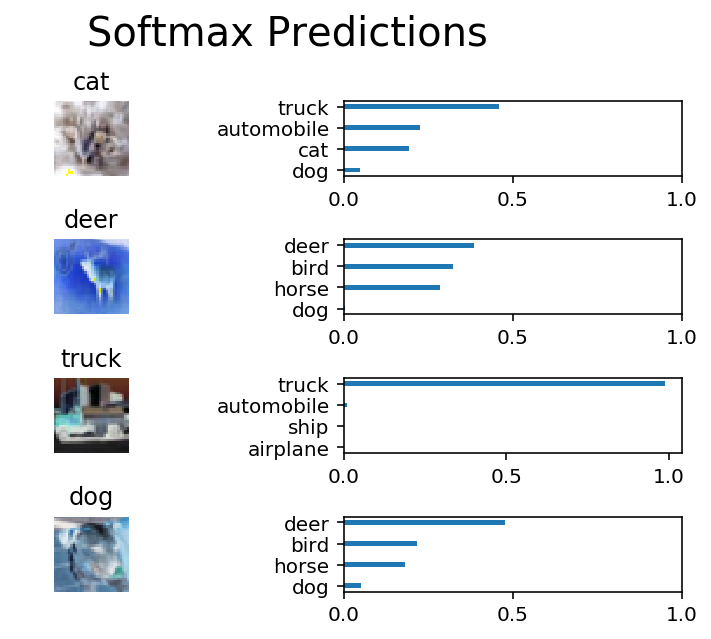

In [124]:
#Calling the function
test_classification_model()

#### By applying simple CNN model on a CIFAR-10 dataset having more than 50000 images, we are able to achive accuracy of more than 60% which is quite good.